# A continuación se encuentra el código utilizado para el trabajo práctico que tiene como objetivo realizar un análisis descriptivo y exploratorio de un dataset que contiene información climática de Australia brindado por la cátedra, junto con la implementación de un modelo para la predicción de la variable "RainTomorrow" que indica si el día siguiente lloverá o no.

## Librerías a utilizar durante el trabajo

In [ ]:
!pip install --force-reinstall -v "numpy == 1.26.4"
!pip install --force-reinstall -v "scikit-learn == 1.5.0"
!pip install pycaret
!pip install shap
!pip install optuna

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Mathematical operations
from math import sqrt, sin, cos, pi
import random

# Preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer

# Model training and evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc, classification_report, 
    matthews_corrcoef, cohen_kappa_score
)

# Oversampling
from imblearn.over_sampling import RandomOverSampler

# Advanced libraries
import shap
import optuna

# PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyCaret
from pycaret.classification import *

# Device selection for PyTorch
device = "cuda" if torch.cuda.is_available() else "cpu"

## Consigna 1

### Carga, limpieza...

In [3]:
df = pd.read_csv('weatherAUS.csv')

Descripción de las variables a utilizar en el trabajo práctico y rango de variación de las mismas:

*   Date: Fecha de la observación meteorológica.
*   Location: Nombre o código de la estación meteorológica.
*   MinTemp: Temperatura mínima registrada en grados Celsius (-8, 30.3).
*   MaxTemp: Temperatura máxima registrada en grados Celsius (4.1, 46.9).
*   Rainfall: Cantidad de lluvia registrada en milímetros (0, 192).
*   Evaporation: Evaporación de agua en milímetros (0, 86.2).
*   Sunshine: Se registraron horas de sol brillante (0, 14.3).
*   WindGustDir: Dirección de la ráfaga de viento según sistema de coordenadas geográficas (W,SSE).
*   WindGustSpeed: Velocidad máxima de la ráfaga de viento en kilómetros por hora (7, 126).
*   WindDir9am: Dirección de la ráfaga de viento a las 9 am (W,SSE).
*   WindDir3pm: Dirección de la ráfaga de viento a las 3 pm (E,NW).
*   WindSpeed9am: Velocidad del viento a las 9 am en kilómetros por hora (0, 87).
*   WindSpeed3pm: Velocidad del viento a las 3 pm en kilómetros por hora (0, 72).
*   Humidity9am: Humedad relativa a las 9 am en porcentaje (1, 100).
*   Humidity3pm: Humedad relativa a las 3 pm en porcentaje (1, 100).
*   Pressure9am: Presión atmosférica a las 9 am en hPa (986.2, 1040.6).
*   Pressure3pm: Presión atmosférica a las 3 pm en hPa (982.6, 1037.9).
*   Cloud9am: Nubosidad a las 9 am en octavas (0, 9).
*   Cloud3pm: Nubosidad a las 3 p.m. en octavas (0, 8).
*   Temp9am: Temperatura a las 9 am en grados Celsius (-1.3, 39.4).
*   Temp3pm: Temperatura a las 3 pm en grados Celsius (3.7, 46.2).
*   RainToday: Variable binaria que indica si llovió hoy (1 para "Sí", 0 para "No").

Nuestra variable de salida o target será 'RainTomorrow'

*   RainTomorrow: variable de destino binaria que indica si lloverá mañana (1 para "Sí", 0 para "No").


In [4]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [5]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [6]:
df.groupby('Location').count()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Location,,,,,,,,,,,,,,,,,,,,,
Adelaide,3193,3191,3190,3091,1704,1769,3167,3167,2919,3177,...,3188,3188,3185,3186,0,0,3188,3189,3091,3090
Albany,3040,2977,2986,3016,2750,2520,0,0,2793,2257,...,2991,2324,3015,3015,3002,2329,3001,2328,3016,3016
Albury,3040,3029,3029,3011,0,0,3008,3008,2515,2994,...,3031,3032,3035,3032,1289,1427,3031,3032,3011,3011
AliceSprings,3040,3039,3038,3032,2825,2520,2989,2989,2810,3036,...,3037,3035,3039,3037,2706,2679,3040,3038,3032,3031
BadgerysCreek,3009,2973,2980,2928,0,0,2933,2933,2574,2924,...,2955,2954,2841,2836,0,0,2968,2965,2928,2928
Ballarat,3040,3039,3039,3028,0,0,3009,3009,2949,3022,...,3019,3033,3016,3014,2494,1992,3028,3034,3028,3028
Bendigo,3040,3038,3035,3034,1185,0,2999,3000,2796,2997,...,3033,3038,3025,3030,2072,2268,3037,3038,3034,3034
Brisbane,3193,3184,3179,3161,3174,3144,3152,3152,3123,3159,...,3189,3178,3192,3185,3192,3191,3189,3178,3161,3161
Cairns,3040,3039,3040,2988,2670,2564,3021,3022,2997,3036,...,3039,3040,3039,3040,2833,2810,3039,3040,2988,2988


In [7]:
df[df['Location'] == 'MountGini']['Location'] = 'MountGinini'

In [8]:
lista = list(df['Location'].unique())

### Selección de localidades aleatoriamente

In [9]:
import random
random.seed(147855)

In [10]:
selected_locations = random.sample(list(df['Location'].unique()), 10)

In [11]:
selected_locations

['Melbourne',
 'Sydney',
 'Albany',
 'WaggaWagga',
 'Albury',
 'CoffsHarbour',
 'Perth',
 'Canberra',
 'NorfolkIsland',
 'Moree']

In [12]:
df = df[df['Location'].isin(selected_locations)]
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123826,2017-06-21,Perth,10.3,19.9,0.2,1.8,7.5,NW,37.0,NNE,...,89.0,60.0,1017.1,1013.8,5.0,6.0,13.0,18.5,No,Yes
123827,2017-06-22,Perth,13.0,16.8,61.2,3.6,0.0,SSW,46.0,W,...,90.0,75.0,1005.6,1008.9,7.0,7.0,16.4,15.6,Yes,No
123828,2017-06-23,Perth,13.3,18.9,0.4,1.8,6.5,SE,37.0,SE,...,85.0,65.0,1019.2,1019.4,6.0,6.0,15.1,18.0,No,No
123829,2017-06-24,Perth,11.5,18.2,0.0,3.8,9.3,SE,30.0,ESE,...,62.0,47.0,1025.9,1023.4,1.0,3.0,14.0,17.6,No,No


In [13]:
df.isna().sum()

Date                0
Location            0
MinTemp           582
MaxTemp           572
Rainfall         1125
Evaporation      7302
Sunshine         8839
WindGustDir      4978
WindGustSpeed    4974
WindDir9am       2158
WindDir3pm       1487
WindSpeed9am      672
WindSpeed3pm     1332
Humidity9am       658
Humidity3pm      1273
Pressure9am      1077
Pressure3pm      1072
Cloud9am         6105
Cloud3pm         6676
Temp9am           572
Temp3pm          1232
RainToday        1125
RainTomorrow     1125
dtype: int64

### Dropeamos NA de la variable respuesta RainTomorrow

In [14]:
df = df.dropna(subset=['RainTomorrow'])

In [15]:
df.isna().sum()

Date                0
Location            0
MinTemp            79
MaxTemp            46
Rainfall          313
Evaporation      7059
Sunshine         8503
WindGustDir      4867
WindGustSpeed    4863
WindDir9am       2080
WindDir3pm       1416
WindSpeed9am      615
WindSpeed3pm     1263
Humidity9am       156
Humidity3pm       763
Pressure9am       544
Pressure3pm       540
Cloud9am         5321
Cloud3pm         5888
Temp9am            71
Temp3pm           722
RainToday         313
RainTomorrow        0
dtype: int64

In [16]:
# Rows donde haya mas de 12 nulls
df.drop(df[df.isnull().sum(axis=1) > 11].index, inplace=True)

### Codificación de variables categóricas

In [17]:
df['RainTomorrow'] = df['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)
df['RainToday'] = df['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)

In [18]:
df['Date'] = pd.to_datetime(df['Date'])

In [19]:
df['Date']

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
123826   2017-06-21
123827   2017-06-22
123828   2017-06-23
123829   2017-06-24
123830   2017-06-25
Name: Date, Length: 29876, dtype: datetime64[ns]

In [20]:
df.loc[:, 'week'] = df['Date'].dt.isocalendar().week

In [21]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,week
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0,49
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0,49
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0,0,49
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0,0,49
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123826,2017-06-21,Perth,10.3,19.9,0.2,1.8,7.5,NW,37.0,NNE,...,60.0,1017.1,1013.8,5.0,6.0,13.0,18.5,0,1,25
123827,2017-06-22,Perth,13.0,16.8,61.2,3.6,0.0,SSW,46.0,W,...,75.0,1005.6,1008.9,7.0,7.0,16.4,15.6,1,0,25
123828,2017-06-23,Perth,13.3,18.9,0.4,1.8,6.5,SE,37.0,SE,...,65.0,1019.2,1019.4,6.0,6.0,15.1,18.0,0,0,25
123829,2017-06-24,Perth,11.5,18.2,0.0,3.8,9.3,SE,30.0,ESE,...,47.0,1025.9,1023.4,1.0,3.0,14.0,17.6,0,0,25


In [22]:
df.loc[:, 'week'] = df['week'].astype(float) / 53.0


df.loc[:, 'sin_week'] = df['week'].apply(lambda x: sin(2 * pi * x))
df.loc[:, 'cos_week'] = df['week'].apply(lambda x: cos(2 * pi * x))

df.drop('week', axis=1, inplace=True)

In [23]:
directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

df['WindGustDir'] = df['WindGustDir'].apply(lambda x: directions.index(x) if x in directions else None)

df['WindGustDir_cos'] = df['WindGustDir'].apply(lambda x: cos(2 * pi * x / 16) if x is not None else None)
df['WindGustDir_sin'] = df['WindGustDir'].apply(lambda x: sin(2 * pi * x / 16) if x is not None else None)

### Separamos en dataset entrenamiento y testeo

In [24]:
y = df['RainTomorrow']
X = df.drop(columns = ['RainTomorrow'])

ros = RandomOverSampler(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

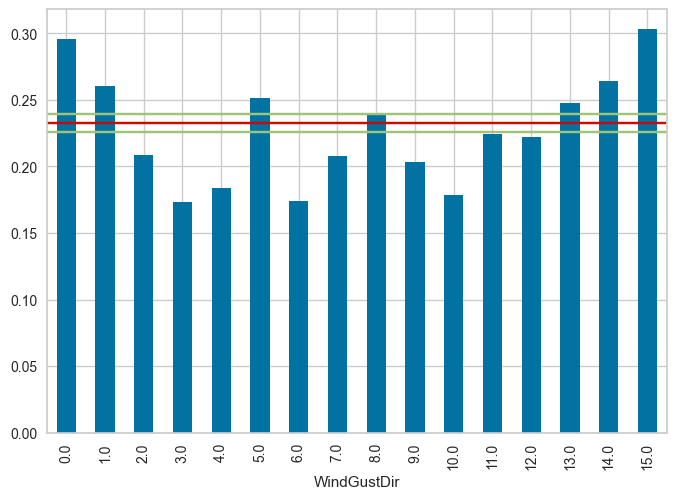

In [26]:
media = y_train.mean()
sd = sqrt((media * (1 - media)) / len(y_train))

train = pd.concat([X_train, y_train], axis=1)

(train.groupby('WindGustDir')['RainTomorrow'].mean()).plot(kind = 'bar')
# Creamos una linea horizontal en el promedio de RainTomorrow
plt.axhline(y=media, color='r', linestyle='-')
plt.axhline(y=media + 2.5 * sd, color='g', linestyle='-')
plt.axhline(y=media - 2.5 * sd, color='g', linestyle='-')

In [27]:
X_train, y_train = ros.fit_resample(X_train, y_train)

In [28]:
X_train.shape

(36688, 26)

In [29]:
y_train.shape

(36688,)

In [30]:
y_test.shape

(5976,)

In [31]:
X_test.shape

(5976, 26)

### Matriz de correlación

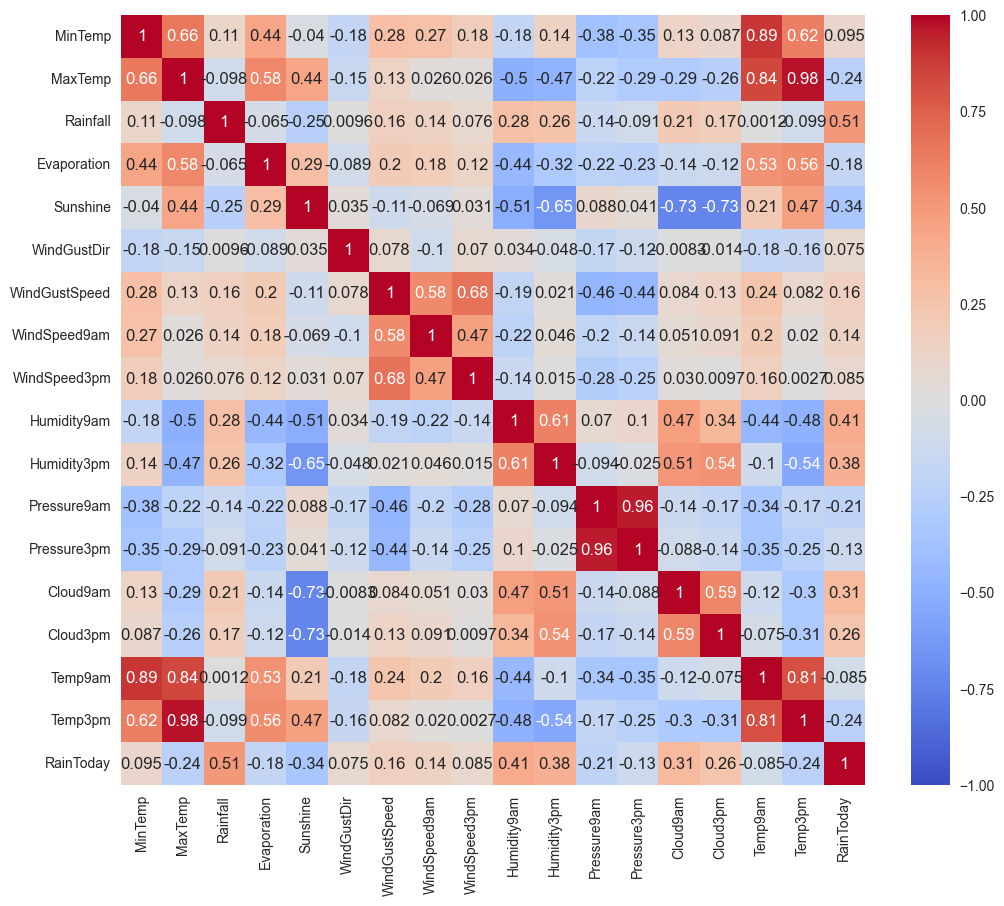

In [32]:
# Tomamos todas las variables numericas
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_train_num = X_train_num.drop(columns = ['sin_week', 'cos_week', 'WindGustDir_cos', 'WindGustDir_sin'])
# Creamos un heatmap con la correlacion de estas variables
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_num.corr(), annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
plt.show()

Temp 9am y 3pm es correlacionado casi perfecto  con min y max temp respectivamente. Por lo que vamos a eliminar alguna de estas.

Ademas, Sunshine este altamente correlacionado negativamente con humidity y cloud tanto 9am como 3pm. Pero tiene mas nulls que las anteriores por lo que tambien dropeo esta fila a pesar de la buena correlacion que tiene con la variable respuesta

(La colinealidad de las variables afecta el modelo lineal)

Ademas, windspeed tanto 9am como 3pm no pareciera tener una correlacion grande por lo que tambien se eliminara

In [33]:
X_test = X_test.drop(['Temp3pm', 'Temp9am', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm', 'WindDir9am', 'WindDir3pm', 'Pressure9am'], axis=1)
X_train = X_train.drop(['Temp3pm', 'Temp9am', 'Sunshine', 'WindSpeed9am', 'WindSpeed3pm','WindDir9am', 'WindDir3pm', 'Pressure9am'], axis=1)

X_train_num = X_train.select_dtypes(include=['int64', 'float64'])
X_train_num = X_train_num.drop(columns = ['sin_week', 'cos_week', 'WindGustDir_cos', 'WindGustDir_sin'])
X_train_cat = X_train.select_dtypes(include=['object'])

X_test_num = X_test.select_dtypes(include=['int64', 'float64'])
X_test_num = X_test_num.drop(columns =  ['sin_week', 'cos_week', 'WindGustDir_cos', 'WindGustDir_sin'])
X_test_cat = X_test.select_dtypes(include=['object'])

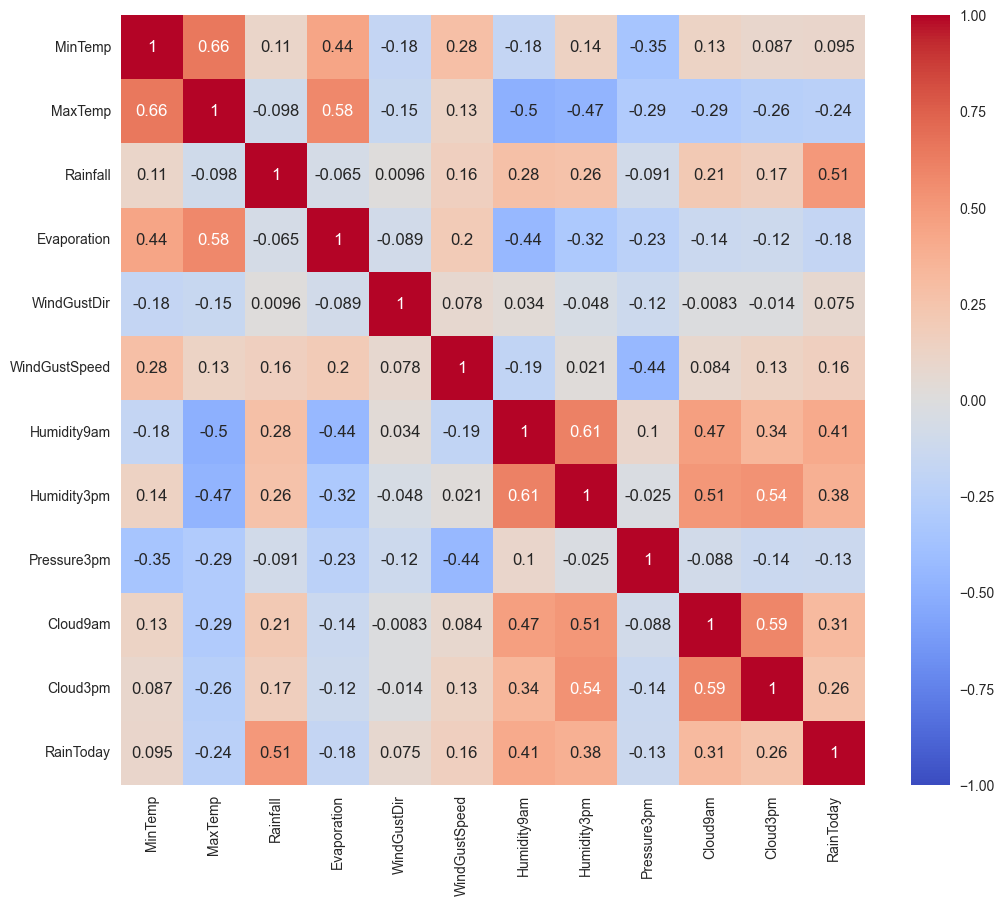

In [34]:
# Creamos un heatmap con la correlacion de las variables restantes
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_num.corr(), annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
plt.show()

### Visualización de las variables

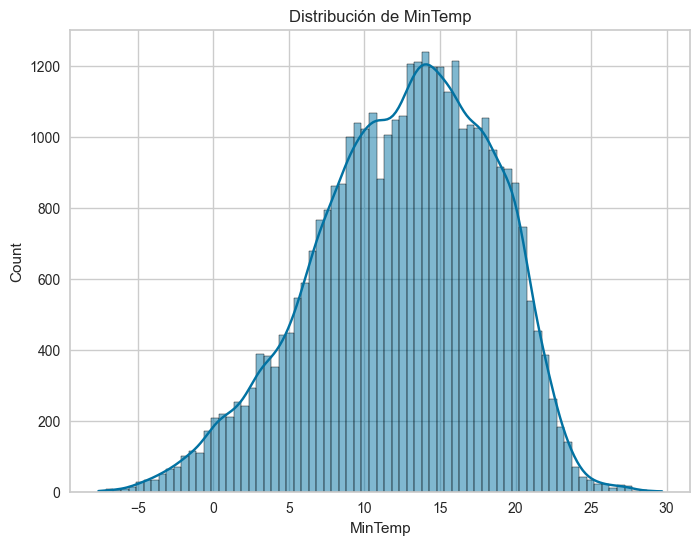

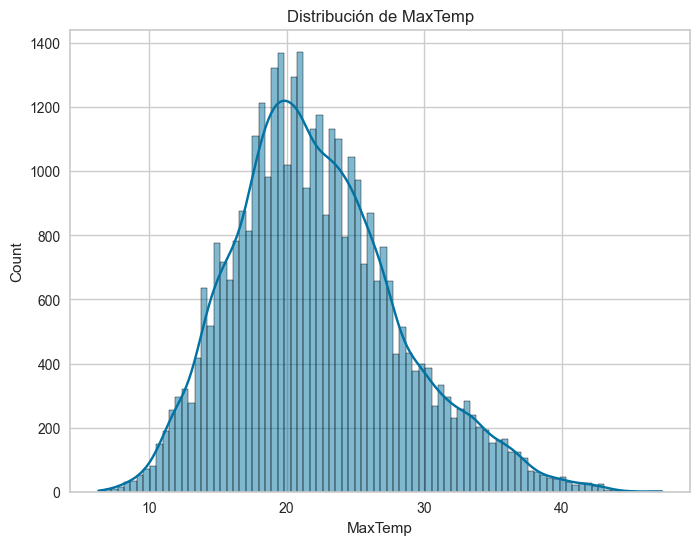

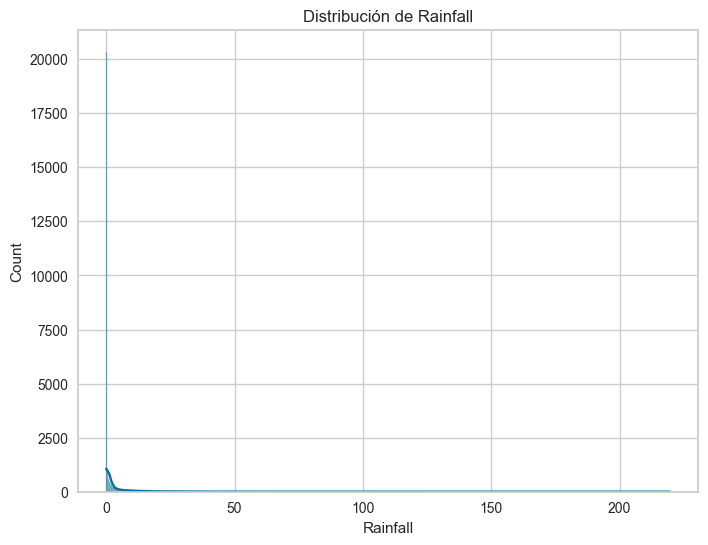

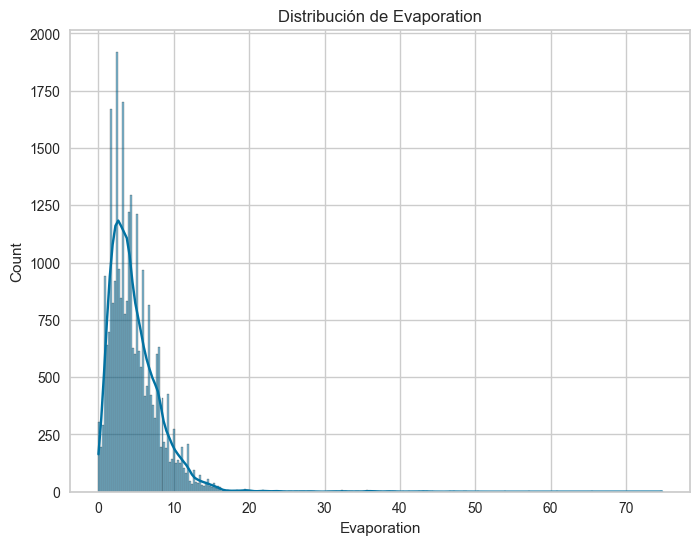

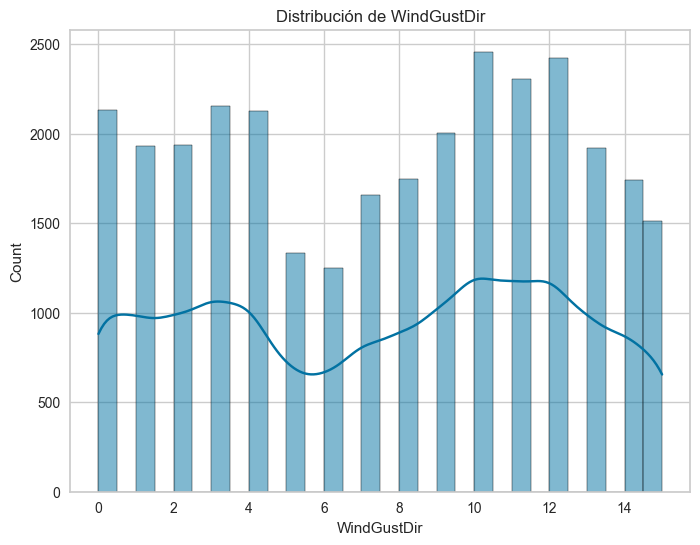

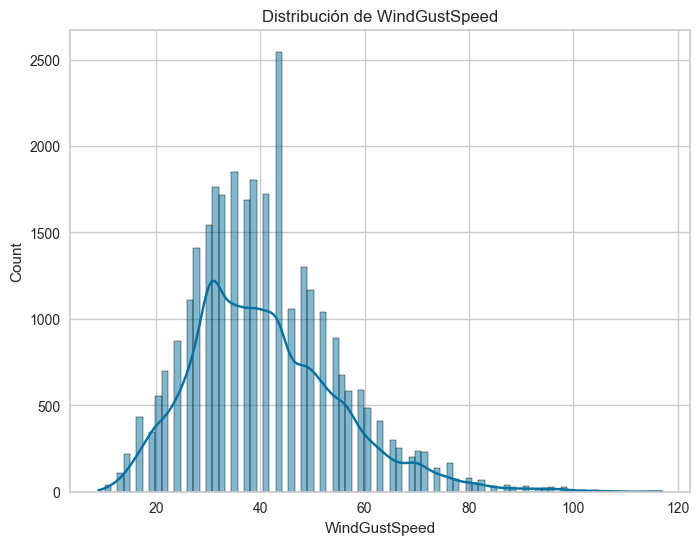

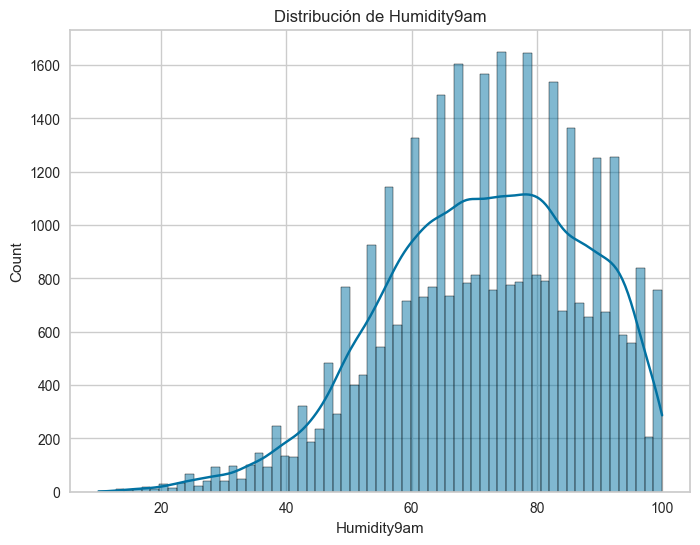

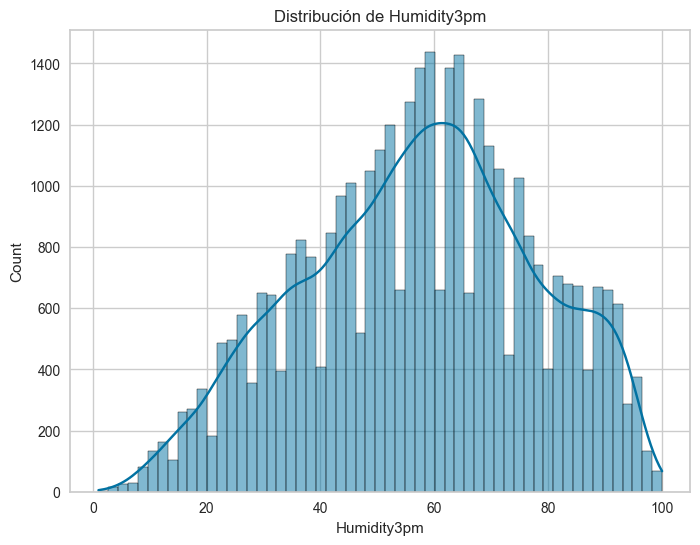

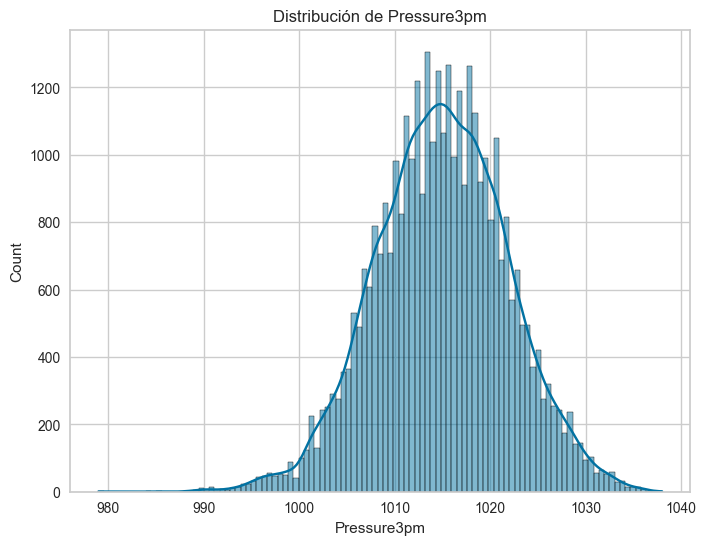

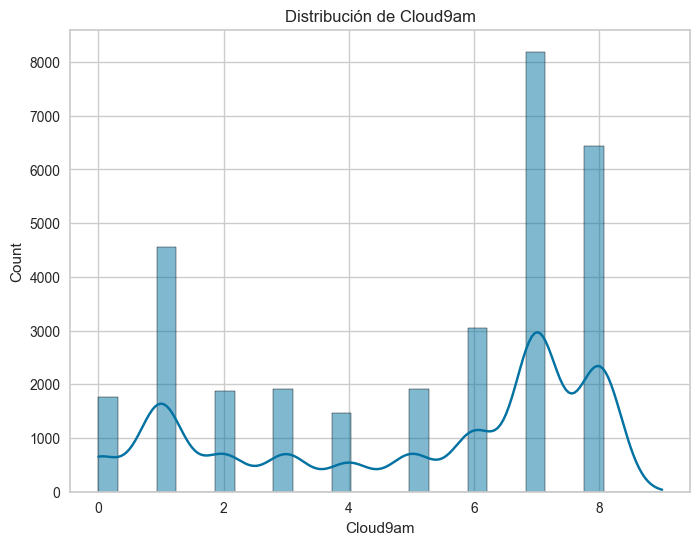

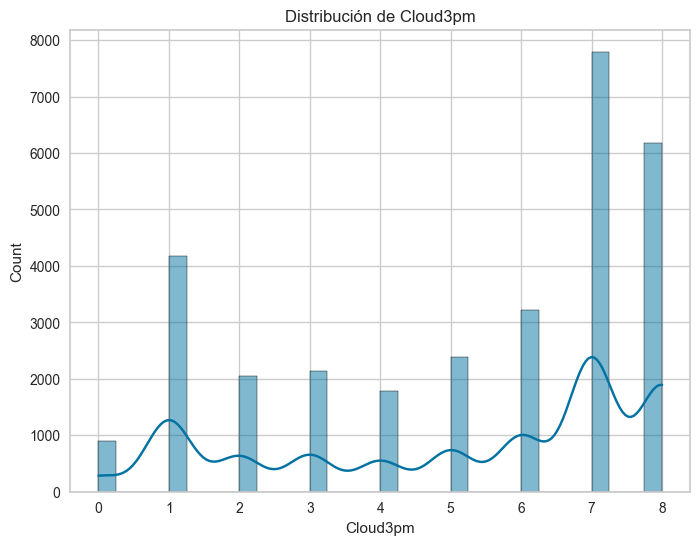

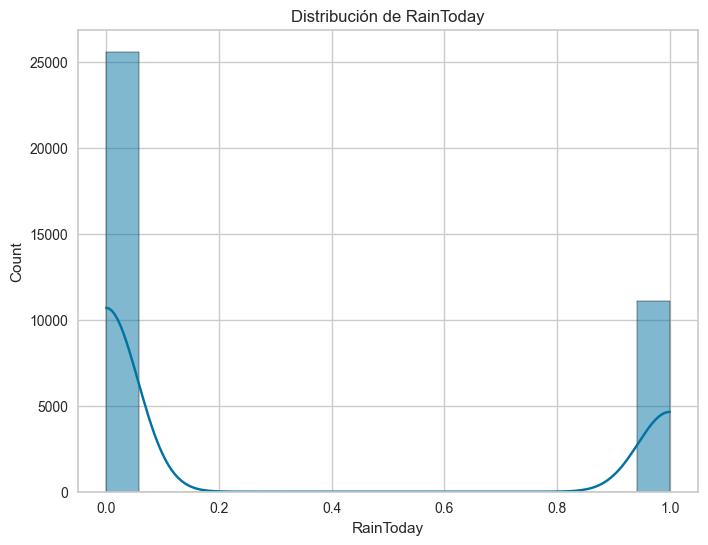

In [35]:
# Visualizamos las distribuciones de estas variables con seaborn
for col in X_train_num.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(X_train_num[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()

Parece que 2 variables (rainfall y evaporation) tienen 2 distribuciones muy asimetricas, capaz se podria transformar.

In [36]:
train.groupby('Cloud9am')['RainTomorrow'].mean()

Cloud9am
0.0    0.035344
1.0    0.091799
2.0    0.158200
3.0    0.181955
4.0    0.224947
5.0    0.239873
6.0    0.282178
7.0    0.345884
8.0    0.461099
9.0    0.000000
Name: RainTomorrow, dtype: float64

Se nota que cloud9am y 3pm aunque sean variables categóricas son ordinales, esto quiere decir que 8 signfica que hay mas nubes que en 7, parece haber solo 2 observaciones con nivel 9, por lo que lo trataremos como datos mal imputados (la probabilidad de lluvia aumenta conforme es mas grande)

In [37]:
# Cambiamos las observaciones con cloud9am = 9.0 a  0
X_train.loc[X_train['Cloud9am'] == 9.0, 'Cloud9am'] = 0
X_test.loc[X_test['Cloud9am'] == 9.0, 'Cloud9am'] = 0

In [38]:
# suma de filas con cloud9am y pm nulls
print(X_train[X_train['Cloud9am'].isnull() & X_train['Cloud3pm'].isnull()].shape)
X_train[X_train['Cloud9am'].isnull() & X_train['Cloud3pm'].isnull() & X_train['RainToday'].isnull()].shape

(4035, 18)


(0, 18)

In [39]:
def impute_cloud_toapply(row):
    if pd.isnull(row['Cloud9am']) and pd.isnull(row['Cloud3pm']):
        row['Cloud9am'] = 1 if row['RainToday'] == 0 else 7
        row['Cloud3pm'] = 1 if row['RainToday'] == 0 else 7
    elif pd.isnull(row['Cloud9am']):
        row['Cloud9am'] = row['Cloud3pm']
    else:
        row['Cloud3pm'] = row['Cloud9am']
    return row

X_train.apply(impute_cloud_toapply, axis=1)
X_test.apply(impute_cloud_toapply, axis=1)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustDir,WindGustSpeed,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,sin_week,cos_week,WindGustDir_cos,WindGustDir_sin
12572,2010-05-21,Moree,10.3,22.3,0.0,3.0,9.0,26.0,64.0,33.0,1015.2,8.0,8.0,0,0.696551,-0.717507,-0.923880,-0.382683
30862,2009-12-18,Sydney,20.2,21.4,5.4,13.6,NaN,NaN,87.0,83.0,1016.7,8.0,8.0,1,-0.234886,0.972023,NaN,NaN
1575,2013-06-22,Albury,-1.3,13.9,0.0,NaN,7.0,15.0,87.0,53.0,1024.8,1.0,1.0,0,0.176890,-0.984231,-0.923880,0.382683
31420,2011-07-29,Sydney,7.3,20.0,0.0,3.6,13.0,22.0,75.0,32.0,1023.6,1.0,1.0,0,-0.403123,-0.915146,0.382683,-0.923880
110477,2014-05-19,Albany,12.7,20.0,12.2,2.0,NaN,NaN,97.0,77.0,1015.4,2.0,2.0,1,0.606800,-0.794854,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48916,2017-03-11,Canberra,9.1,30.1,0.0,NaN,14.0,31.0,94.0,28.0,1010.0,1.0,1.0,0,0.926690,0.375828,0.707107,-0.707107
9344,2009-10-14,CoffsHarbour,13.3,28.5,0.0,8.0,14.0,69.0,27.0,13.0,1001.1,0.0,0.0,0,-0.964636,0.263587,0.707107,-0.707107
9519,2010-04-07,CoffsHarbour,19.7,25.0,0.0,2.2,0.0,41.0,67.0,60.0,1016.3,8.0,8.0,0,0.996050,-0.088796,1.000000,0.000000
2924,2017-03-02,Albury,17.7,34.5,0.0,NaN,6.0,35.0,58.0,31.0,1014.5,1.0,1.0,0,0.875735,0.482792,-0.707107,0.707107


In [40]:
X

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,sin_week,cos_week,WindGustDir_cos,WindGustDir_sin
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,12.0,44.0,W,...,1007.1,8.0,NaN,16.9,21.8,0,-0.456629,0.889657,-1.836970e-16,-1.000000
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,13.0,44.0,NNW,...,1007.8,NaN,NaN,17.2,24.3,0,-0.456629,0.889657,3.826834e-01,-0.923880
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,11.0,46.0,W,...,1008.7,NaN,2.0,21.0,23.2,0,-0.456629,0.889657,-3.826834e-01,-0.923880
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,2.0,24.0,SE,...,1012.8,NaN,NaN,18.1,26.5,0,-0.456629,0.889657,7.071068e-01,0.707107
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,12.0,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,0,-0.456629,0.889657,-1.836970e-16,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123826,2017-06-21,Perth,10.3,19.9,0.2,1.8,7.5,14.0,37.0,NNE,...,1013.8,5.0,6.0,13.0,18.5,0,0.176890,-0.984231,7.071068e-01,-0.707107
123827,2017-06-22,Perth,13.0,16.8,61.2,3.6,0.0,9.0,46.0,W,...,1008.9,7.0,7.0,16.4,15.6,1,0.176890,-0.984231,-9.238795e-01,-0.382683
123828,2017-06-23,Perth,13.3,18.9,0.4,1.8,6.5,6.0,37.0,SE,...,1019.4,6.0,6.0,15.1,18.0,0,0.176890,-0.984231,-7.071068e-01,0.707107
123829,2017-06-24,Perth,11.5,18.2,0.0,3.8,9.3,6.0,30.0,ESE,...,1023.4,1.0,3.0,14.0,17.6,0,0.176890,-0.984231,-7.071068e-01,0.707107


In [41]:
# Dropeamos Date Location y Windgust
X_train = X_train.drop(['Date', 'Location', 'WindGustDir'], axis=1)
X_test = X_test.drop(['Date', 'Location', 'WindGustDir'], axis=1)

In [42]:
X_train_num = X_train.select_dtypes(include=['int64', 'float64'])

### Estandarización

In [43]:
cols = X_train_num.columns
cols = cols.drop(labels = ['RainToday', 'Cloud9am', 'Cloud3pm', 'sin_week', 'cos_week', 'WindGustDir_cos', 'WindGustDir_sin'])
# Cloud9am y 3pm es ordinal y tienen relacion lineal con la variable respuesta
# asi que se quedan asi
cols

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed',
       'Humidity9am', 'Humidity3pm', 'Pressure3pm'],
      dtype='object')

In [44]:
# Normalizamos con PowerScaler las columnas numericas
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

# Escalamos entre 0 y 1 Cloud
X_train['Cloud9am'] = X_train['Cloud9am'] / 8
X_test['Cloud9am'] = X_test['Cloud9am'] / 8
X_train['Cloud3pm'] = X_train['Cloud3pm'] / 8
X_test['Cloud3pm'] = X_test['Cloud3pm'] / 8

### Análisis y decisión sobre datos faltantes

In [45]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed',
       'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'RainToday', 'sin_week', 'cos_week', 'WindGustDir_cos',
       'WindGustDir_sin'],
      dtype='object')

In [46]:
sqrt(len(X_train))

191.54111830100607

In [47]:
# Imputamos la moda en las varibles categoricas (RainToday, Windgust, 'Cloud9am', 'Cloud3pm')
RainToday_mode = X_train['RainToday'].mode()[0]
X_train['RainToday'].fillna(RainToday_mode, inplace=True)
X_test['RainToday'].fillna(RainToday_mode, inplace=True)

#WindGust_mode = X_train['WindGust'].mode()[0]
#X_train['WindGust'].fillna(WindGust_mode, inplace=True)
#X_test['WindGust'].fillna(WindGust_mode, inplace=True)

#Cloud9am_mode = X_train['Cloud9am'].mode()[0]
#X_train['Cloud9am'].fillna(Cloud9am_mode, inplace=True)
#X_test['Cloud9am'].fillna(Cloud9am_mode, inplace=True)

#Cloud3pm_mode = X_train['Cloud3pm'].mode()[0]
#X_train['Cloud3pm'].fillna(Cloud3pm_mode, inplace=True)
#X_test['Cloud3pm'].fillna(Cloud3pm_mode, inplace=True)

# Completamos datos faltantes por kmeans

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=155)
X_train = pd.DataFrame(imputer.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), index=X_test.index, columns=X_test.columns)


In [48]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,sin_week,cos_week,WindGustDir_cos,WindGustDir_sin
0,-0.845066,-0.767349,1.356456,-1.041352,-1.532869,0.838811,-0.365799,-0.222093,0.375000,0.250000,1.0,-0.176890,-0.984231,-0.382683,-0.923880
1,-0.367558,-0.708951,1.313071,0.133911,0.597324,-1.115524,-0.414533,0.965492,0.125000,0.125000,1.0,-0.606800,-0.794854,-0.923880,0.382683
2,0.486044,1.158751,-0.780205,0.287420,-0.646473,0.287800,0.172964,-0.034083,0.502419,1.000000,0.0,0.964636,0.263587,0.923880,-0.382683
3,-0.625542,-0.354061,0.247961,-0.234797,-0.646473,-0.104868,-0.754385,0.683454,0.875000,0.500000,0.0,-0.964636,0.263587,0.382683,0.923880
4,-0.488539,-0.613113,-0.501445,-0.497487,-0.158905,-0.418119,-0.560466,2.315414,0.550806,0.440323,0.0,-0.999561,0.029633,-0.707107,-0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36683,-1.902709,-1.692100,-0.780205,-0.696093,-0.734535,0.981329,1.712808,-0.265340,1.000000,1.000000,0.0,-0.176890,-0.984231,0.923880,-0.382683
36684,0.650183,0.836053,1.231081,0.110980,1.732711,0.628577,0.815256,-1.006708,0.798387,0.500000,1.0,0.964636,0.263587,-0.707107,-0.707107
36685,0.215166,-0.846297,1.677878,-0.804094,0.393487,1.875078,1.362732,-0.808638,1.000000,1.000000,1.0,-0.606800,-0.794854,0.238893,-0.113575
36686,-0.122718,-0.318106,1.452042,-0.004888,-1.532869,1.721604,0.271411,0.140338,1.000000,0.875000,1.0,0.292057,-0.956401,-0.707107,-0.707107


In [49]:
(abs(X_train) > 3).sum()

MinTemp              3
MaxTemp             56
Rainfall             0
Evaporation         87
WindGustSpeed       68
Humidity9am          0
Humidity3pm          0
Pressure3pm        108
Cloud9am             0
Cloud3pm             0
RainToday            0
sin_week             0
cos_week             0
WindGustDir_cos      0
WindGustDir_sin      0
dtype: int64

## Consigna 2

In [50]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,RainToday,sin_week,cos_week,WindGustDir_cos,WindGustDir_sin
0,-0.845066,-0.767349,1.356456,-1.041352,-1.532869,0.838811,-0.365799,-0.222093,0.375000,0.250000,1.0,-0.176890,-0.984231,-0.382683,-0.923880
1,-0.367558,-0.708951,1.313071,0.133911,0.597324,-1.115524,-0.414533,0.965492,0.125000,0.125000,1.0,-0.606800,-0.794854,-0.923880,0.382683
2,0.486044,1.158751,-0.780205,0.287420,-0.646473,0.287800,0.172964,-0.034083,0.502419,1.000000,0.0,0.964636,0.263587,0.923880,-0.382683
3,-0.625542,-0.354061,0.247961,-0.234797,-0.646473,-0.104868,-0.754385,0.683454,0.875000,0.500000,0.0,-0.964636,0.263587,0.382683,0.923880
4,-0.488539,-0.613113,-0.501445,-0.497487,-0.158905,-0.418119,-0.560466,2.315414,0.550806,0.440323,0.0,-0.999561,0.029633,-0.707107,-0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36683,-1.902709,-1.692100,-0.780205,-0.696093,-0.734535,0.981329,1.712808,-0.265340,1.000000,1.000000,0.0,-0.176890,-0.984231,0.923880,-0.382683
36684,0.650183,0.836053,1.231081,0.110980,1.732711,0.628577,0.815256,-1.006708,0.798387,0.500000,1.0,0.964636,0.263587,-0.707107,-0.707107
36685,0.215166,-0.846297,1.677878,-0.804094,0.393487,1.875078,1.362732,-0.808638,1.000000,1.000000,1.0,-0.606800,-0.794854,0.238893,-0.113575
36686,-0.122718,-0.318106,1.452042,-0.004888,-1.532869,1.721604,0.271411,0.140338,1.000000,0.875000,1.0,0.292057,-0.956401,-0.707107,-0.707107


### Implementamos el modelo de clasificación con regresión logística

In [51]:
logreg = LogisticRegression(random_state=0, max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

### Cálculo de métricas

In [52]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")        # Promedio ponderado entre precisión y recall

Accuracy: 0.7737617135207496
Precision: 0.5090819833087874
Recall: 0.7465802735781137
F1 Score: 0.6053706946876825


### Matriz de confusión

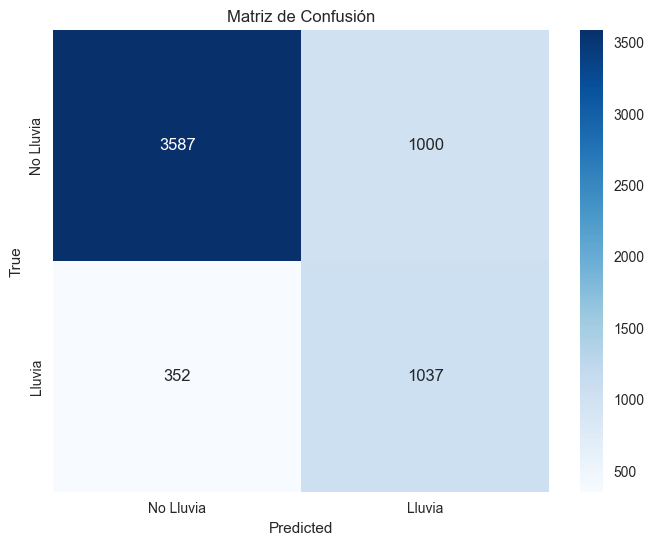

In [53]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lluvia", "Lluvia"], yticklabels=["No Lluvia", "Lluvia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()

Falsos positivos: Casos en que se predice lluvia para el día siguiente, pero que no sucedió.

Falsos negativos: Casos en que se predice que no lloverá al día siguiene y luego llueve.

### Curva ROC y el AUC

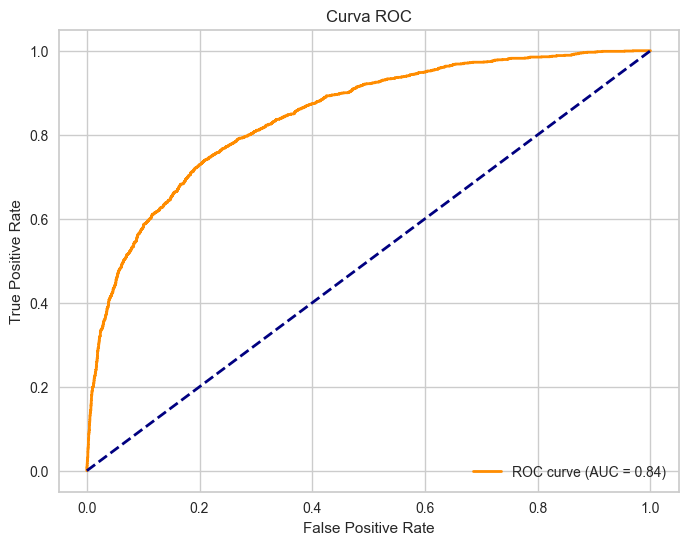

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Analizar el mejor umbral

In [58]:
#for threshold in thresholds:
#    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
#    precision_adjusted = precision_score(y_test, y_pred_adjusted)
#    recall_adjusted = recall_score(y_test, y_pred_adjusted)
#    f1_adjusted = f1_score(y_test, y_pred_adjusted)
    #print(f"Threshold: {threshold:.2f}, Precision: {precision_adjusted:.2f}, Recall: {recall_adjusted:.2f}, F1: {f1_adjusted:.2f}")

Threshold: 0.50, Precision: 0.51, Recall: 0.75, F1: 0.61

Threshold: 0.69, Precision: 0.64, Recall: 0.57, F1: 0.61


AUC : (El área bajo la curva es de 0.84, lo cual indica un modelo aceptable, recordando que un modelo aleatorio tendría un área de 0.5)




Dependiendo la métrica que quiera optimizarse, pueden elegirse diferentes umbrales.
Los umbrales que maximizan F1 (buscaría un mejor equilibrio entre presición y recall) se encuentran entre 0.50 y 0.69.

En ese rango de umbral, podríamos optar por maximizar Presición o Recall dependiendo lo que se busque en contexto. Maximizar presición podría predecir lluvia cuando en realidad no suceda, y viceversa con recall, no predecir lluvia cuando en realidad si suceda.

## Consigna 3

In [57]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)   # feature_importances_ que mide la importancia de cada característica para el modelo, convertimos a una serie
top_features = feature_importances.nlargest(2).index.tolist()                           # nlargest(2) selecciona las 2 características con los valores más altos de importancia, .tolist() para convertir los índices a lista

print("Las dos características principales son:", top_features)

Las dos características principales son: ['Humidity3pm', 'Cloud3pm']


In [55]:
X_train['Humidity3pm'].describe()

count    36688.000000
mean         0.009970
std          0.991616
min         -2.664173
25%         -0.705979
50%          0.074661
75%          0.716090
max          2.114353
Name: Humidity3pm, dtype: float64

In [56]:
X_train['Cloud3pm'].describe()

count    36688.000000
mean         0.627690
std          0.305976
min          0.000000
25%          0.375000
50%          0.723387
75%          0.875000
max          1.000000
Name: Cloud3pm, dtype: float64

In [58]:
X_test['Cloud3pm']

12572     0.625000
30862     1.000000
1575      0.520968
31420     0.325806
110477    0.500000
            ...   
48916     0.437903
9344      0.250000
9519      1.000000
2924      0.301613
122881    0.750000
Name: Cloud3pm, Length: 5976, dtype: float64

In [59]:
humidity_threshold = 0
cloud_threshold = 0

y_regla_bi_var = []
for i in range(len(X_test)):
    humidity = X_test['Humidity3pm'].iloc[i]
    cloud = X_test['Cloud3pm'].iloc[i]

    if humidity > humidity_threshold and cloud > cloud_threshold:
        y_regla_bi_var.append(1)
    else:
        y_regla_bi_var.append(0)

print(classification_report(y_test, y_regla_bi_var))

mcc = matthews_corrcoef(y_test, y_regla_bi_var)     # correlación entre las predicciones y las etiquetas reales, MCC de +1 indica una predicción perfecta

print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

kappa = cohen_kappa_score(y_test, y_regla_bi_var)   # nivel de acuerdo entre las predicciones del modelo y las etiquetas reales, ajustando por la probabilidad de acuerdo que ocurriría al azar

print(f"Cohen's Kappa: {kappa:.2f}")

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      4587
           1       0.43      0.73      0.54      1389

    accuracy                           0.71      5976
   macro avg       0.66      0.72      0.66      5976
weighted avg       0.79      0.71      0.73      5976

Matthews Correlation Coefficient (MCC): 0.37
Cohen's Kappa: 0.35


In [60]:
conf_matrix = confusion_matrix(y_test, y_regla_bi_var)
print("Matriz de confusión:\n", conf_matrix)

Matriz de confusión:
 [[3242 1345]
 [ 381 1008]]


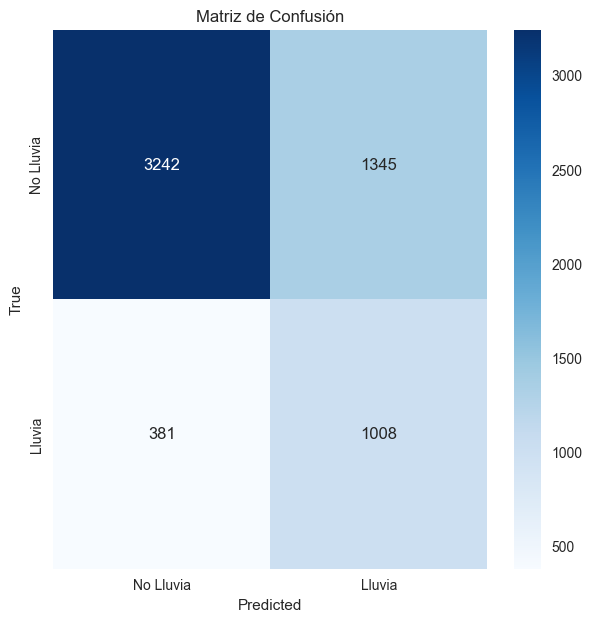

In [61]:
plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Lluvia", "Lluvia"], yticklabels=["No Lluvia", "Lluvia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()

In [62]:
tn, fp, fn, tp = confusion_matrix(y_test, y_regla_bi_var).ravel()

print(f"Falsos Positivos : {fp}  ; Falsos Negativos : {fn}")

Falsos Positivos : 1345  ; Falsos Negativos : 381


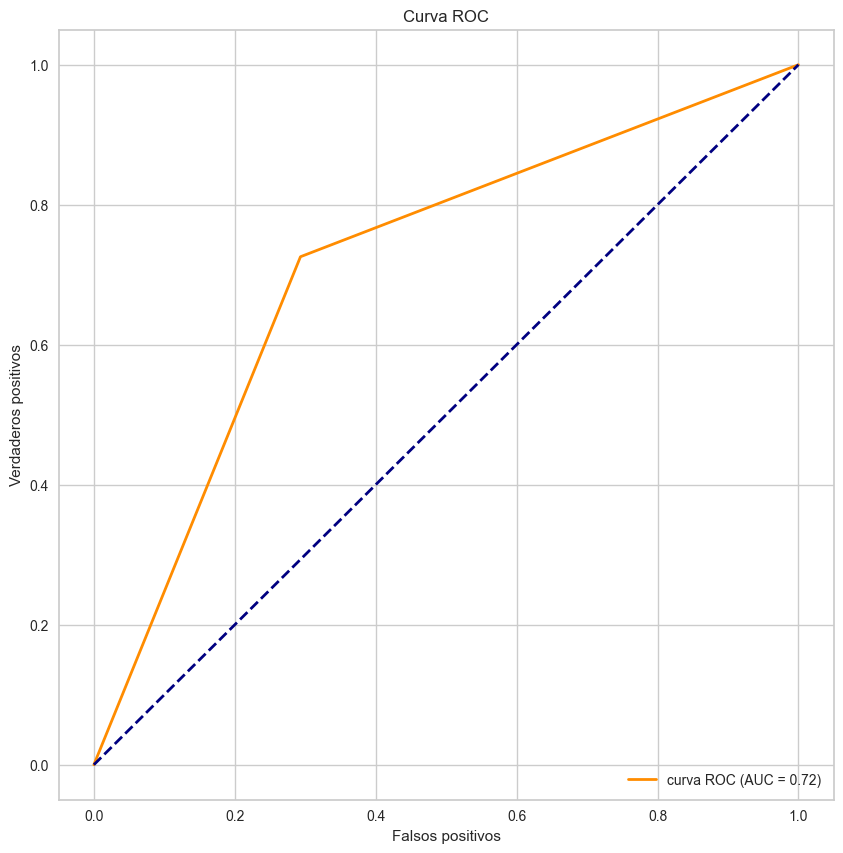

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_regla_bi_var)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [64]:
f1 = f1_score(y_test, y_regla_bi_var)
print(f"F1 Score: {f1}")

F1 Score: 0.5387493319080705


In [65]:
for threshold in thresholds:
    y_pred_adjusted = (y_regla_bi_var >= threshold).astype(int)
    precision_adjusted = precision_score(y_test, y_pred_adjusted, zero_division=1)
    recall_adjusted = recall_score(y_test, y_pred_adjusted)
    f1_adjusted = f1_score(y_test, y_pred_adjusted)
    print(f"Threshold: {threshold:.2f}, Precision: {precision_adjusted:.2f}, Recall: {recall_adjusted:.2f}, F1: {f1_adjusted:.2f}")

Threshold: inf, Precision: 1.00, Recall: 0.00, F1: 0.00
Threshold: 1.00, Precision: 0.43, Recall: 0.73, F1: 0.54
Threshold: 0.00, Precision: 0.23, Recall: 1.00, F1: 0.38


Hemos conseguido fitting regular con modelo base.

El área bajo la curva ha sido inferior en el modelo base implementado (0.72 vs 0.84), y hemos analizado otras métricas como Matthews Correlation Coefficient (MCC) (0.37) y Cohen's Kappa (0.35). 

MCC nos indican la correlación entre las predicciones y las etiquetas reales teniendo en cuenta verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.

Cohen's Kappa mide el acuerdo entre las predicciones del modelo y las etiquetas reales, ajustando el valor en función de las predicciones que se podrían haber hecho al azar. Si bien puede ser útil en problemas multiclase, nos pareció una métrica interesante a la hora de analizar si el modelo busca más allá de una predicción aleatoria.

## Consigna 4

In [66]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=0, max_iter=1000)
logreg_cv.fit(X_train, y_train)

y_pred_cv = logreg_cv.predict(X_test)
y_pred_proba_cv = logreg_cv.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      4587
           1       0.51      0.75      0.61      1389

    accuracy                           0.77      5976
   macro avg       0.71      0.76      0.72      5976
weighted avg       0.82      0.77      0.79      5976



Aun con cv de 5 folds, tenemos unas metricas similares.

Para optimizar hiperparametros vamos a utilizar optuna debido a su eficiencia, utilizando f1 para la variable de lluvia positiva

In [67]:
def objective(trial):
    # Definimos los parametros a optimizar

    C = trial.suggest_int('Cs', 1, 200)
    max_iter = trial.suggest_int('max_iter', 100, 2000)

    params = {'Cs': C, 'max_iter': max_iter}

    logreg_optuna = LogisticRegressionCV(cv=5, random_state=0, **params)
    logreg_optuna.fit(X_train, y_train)

    y_pred_optuna = logreg_optuna.predict(X_test)
    f1_optuna = f1_score(y_test, y_pred_optuna)
    return f1_optuna

In [68]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_params = study.best_params

[I 2024-11-23 17:20:33,769] A new study created in memory with name: no-name-e6ba0830-1ea8-4a3f-81dc-4b0f2d46adc3
[I 2024-11-23 17:20:36,835] Trial 0 finished with value: 0.6047869235259778 and parameters: {'Cs': 47, 'max_iter': 1114}. Best is trial 0 with value: 0.6047869235259778.
[I 2024-11-23 17:20:45,803] Trial 1 finished with value: 0.604610446454625 and parameters: {'Cs': 175, 'max_iter': 679}. Best is trial 0 with value: 0.6047869235259778.
[I 2024-11-23 17:20:50,971] Trial 2 finished with value: 0.6055474452554744 and parameters: {'Cs': 89, 'max_iter': 1582}. Best is trial 2 with value: 0.6055474452554744.
[I 2024-11-23 17:20:57,924] Trial 3 finished with value: 0.6051401869158879 and parameters: {'Cs': 132, 'max_iter': 1913}. Best is trial 2 with value: 0.6055474452554744.
[I 2024-11-23 17:21:01,025] Trial 4 finished with value: 0.604963503649635 and parameters: {'Cs': 45, 'max_iter': 648}. Best is trial 2 with value: 0.6055474452554744.
[I 2024-11-23 17:21:07,757] Trial 5 fi

La mejoria es casi nula debido a la simplicidad de una regresion logistica y sus hiperparametros, capaz en un modelo mas complejo seria notoria

## Consigna 5

In [69]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=0, **best_params)
logreg_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=89, cv=5, max_iter=1582, random_state=0)

In [70]:
y_pred_cv = logreg_cv.predict(X_test)
explainer = shap.Explainer(logreg_cv, X_train)
shap_values = explainer(X_test)

print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      4587
           1       0.51      0.75      0.61      1389

    accuracy                           0.77      5976
   macro avg       0.71      0.76      0.72      5976
weighted avg       0.82      0.77      0.79      5976



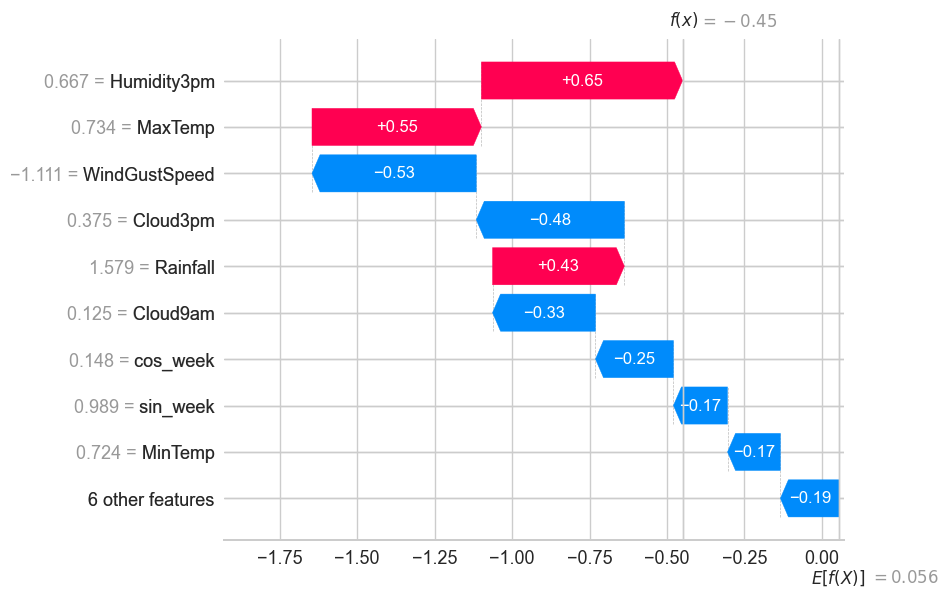

In [71]:
index=38
feature_names=X_test.columns.values
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value, # se muestra como un punto de partida específico para la instancia seleccionada
                               feature_names=feature_names)
shap.plots.waterfall(explanation)

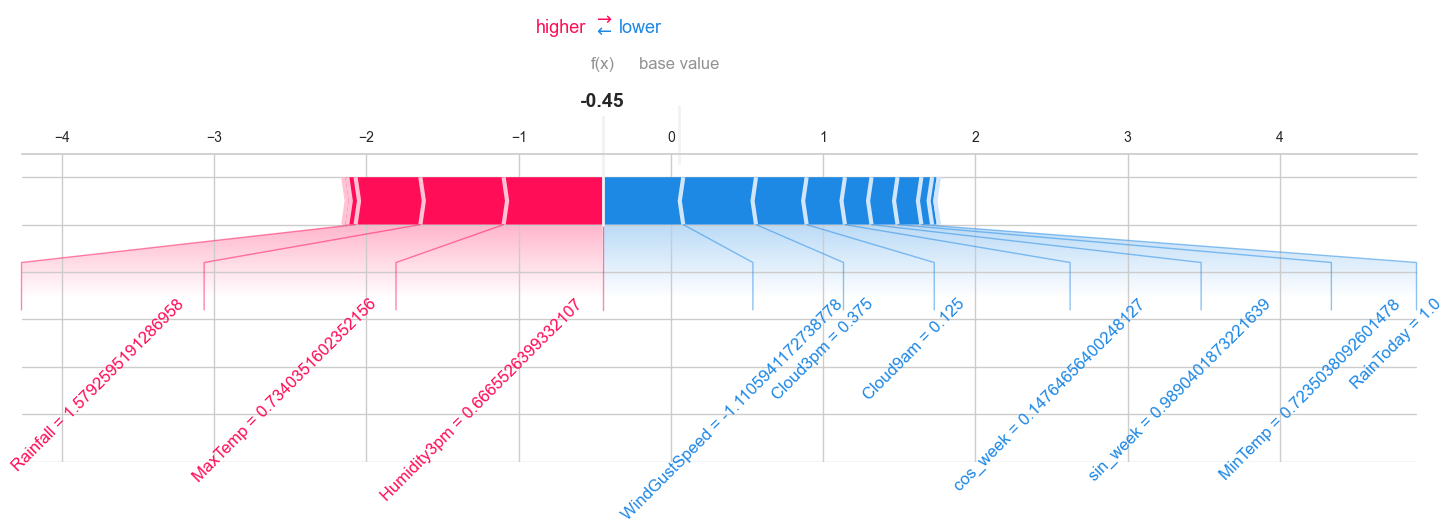

In [72]:
shap.force_plot(
    explainer.expected_value,     # se interpreta como el valor base global, por eso dan distintos números
    shap_values[index].values,    # valores SHAP de la instancia seleccionada
    X_test.iloc[index],           # seleccionamos al fila específica
    feature_names=feature_names,  
    matplotlib=True, 
    figsize=(18, 4),
    text_rotation=45
)

In [73]:
X_test.iloc[index]

MinTemp            0.723504
MaxTemp            0.734035
Rainfall           1.579260
Evaporation       -0.078393
WindGustSpeed     -1.110594
Humidity9am        0.559453
Humidity3pm        0.666553
Pressure3pm        0.257087
Cloud9am           0.125000
Cloud3pm           0.375000
RainToday          1.000000
sin_week           0.989040
cos_week           0.147647
WindGustDir_cos    0.923880
WindGustDir_sin    0.382683
Name: 10875, dtype: float64

In [74]:
df.iloc[index]

Date               2009-01-09 00:00:00
Location                        Albury
MinTemp                           12.5
MaxTemp                           28.4
Rainfall                           0.0
Evaporation                        NaN
Sunshine                           NaN
WindGustDir                        2.0
WindGustSpeed                     37.0
WindDir9am                         SSE
WindDir3pm                           S
WindSpeed9am                      20.0
WindSpeed3pm                       9.0
Humidity9am                       38.0
Humidity3pm                       16.0
Pressure9am                     1017.8
Pressure3pm                     1013.7
Cloud9am                           NaN
Cloud3pm                           NaN
Temp9am                           17.2
Temp3pm                           26.6
RainToday                            0
RainTomorrow                         0
sin_week                      0.234886
cos_week                      0.972023
WindGustDir_cos          

Pudimos ver que en esta observación, si bien las dos variables con mayor influencia en el modelo ("Humidity3pm","MaxTemp") nos podría haber indicado una gran probabilidad de lluvia para el día siguiente, el resto de las variables bajaron significativamente la estimación para concluir de manera acertada en la predicción. 

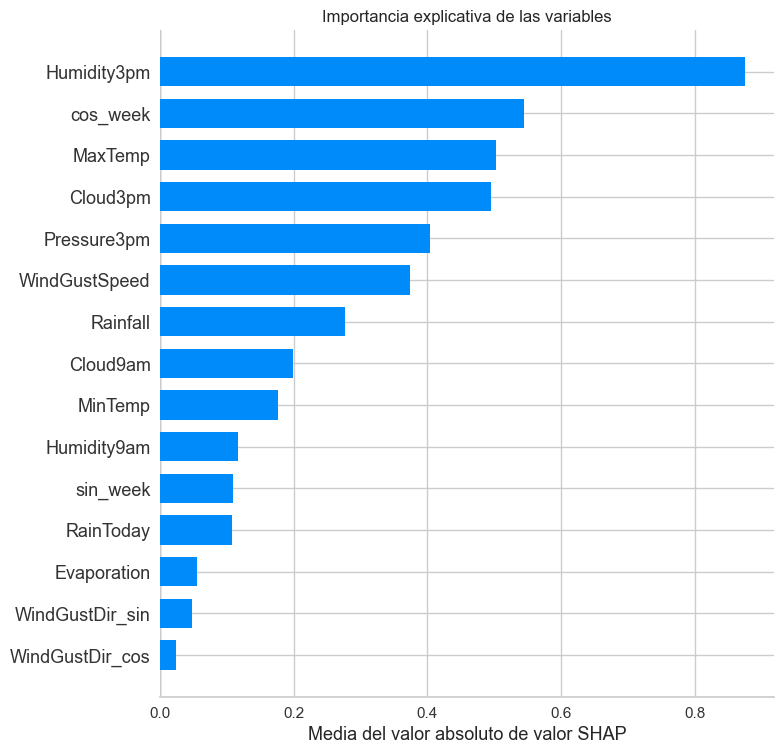

In [75]:
shap.summary_plot(shap_values, X_train, plot_type="bar", show = False)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('Media del valor absoluto de valor SHAP')
ax.set_title('Importancia explicativa de las variables')
plt.show()

En este grafico se nota la importancia del valor absoluto SHAP de cada variable, pero no se logra distinguir si nos da menos o mas chances logaritmicas de la lluvia, ademas de no saber en que valores de cada variable se obtienen estas chances.

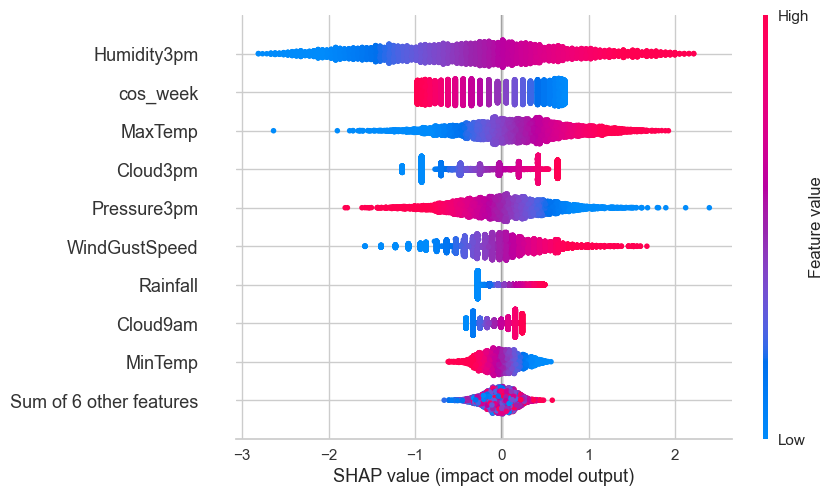

In [76]:
shap.plots.beeswarm(shap_values)

En linea con lo visto anteriormente, humedad 3pm tiene una importancia predictiva alta. Al ser un modelo lineal, se nota el gradiente en todas las variables, ya sea de valores altos a bajos o viceversa.

## Consigna 6

In [77]:
model_setup = setup(data = X_train, target = y_train, session_id = 123)

,Description,Value
0,Session id,123
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(36688, 16)"
4,Transformed data shape,"(36688, 16)"
5,Transformed train set shape,"(25681, 16)"
6,Transformed test set shape,"(11007, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [78]:
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:25:32
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9322,0.9816,0.9386,0.9269,0.9327,0.8645,0.8646,0.4910
rf,Random Forest Classifier,0.9204,0.9785,0.9506,0.8966,0.9228,0.8409,0.8425,0.7160
dt,Decision Tree Classifier,0.8748,0.8748,0.9418,0.8305,0.8827,0.7495,0.7564,0.0560
lightgbm,Light Gradient Boosting Machine,0.8234,0.9079,0.8372,0.8149,0.8258,0.6468,0.6472,0.2720
knn,K Neighbors Classifier,0.7979,0.8771,0.8463,0.7716,0.8072,0.5957,0.5986,0.6620
gbc,Gradient Boosting Classifier,0.7897,0.8744,0.7853,0.7924,0.7888,0.5794,0.5795,0.8270
lr,Logistic Regression,0.7768,0.8601,0.7738,0.7784,0.7761,0.5535,0.5536,0.7320
ridge,Ridge Classifier,0.7758,0.8598,0.7719,0.7780,0.7749,0.5516,0.5516,0.0210
lda,Linear Discriminant Analysis,0.7758,0.8598,0.7720,0.7780,0.7750,0.5517,0.5517,0.0250
svm,SVM - Linear Kernel,0.7727,0.8556,0.7742,0.7730,0.7727,0.5454,0.5466,0.0410


In [79]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [80]:
predictions= predict_model(best, data = X_test)

In [81]:
print(classification_report(y_test, predictions['prediction_label']))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4587
           1       0.71      0.51      0.59      1389

    accuracy                           0.84      5976
   macro avg       0.79      0.72      0.75      5976
weighted avg       0.83      0.84      0.83      5976



Este modelo nos sesga a pensar que es mucho mejor que la regresion logistica, pero viendo el detalle de las metricas en realidad tiene una performance similar, tiendo una recall mas baja a cambio de mas precision cuando llueve

## Consigna 7

In [72]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features = len(X_train.columns), out_features = 8)
        self.relu = nn.LeakyReLU(0.1)
        self.lin2 = nn.Linear(in_features = 8, out_features = 4)
        self.relu2 = nn.LeakyReLU(0.1)
        self.lin3 = nn.Linear(in_features = 4, out_features = 1)
        #self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.relu2(x)
        x = self.lin3(x)
        return x

nntwk = NeuralNetwork()
nntwk.to(device)
print(nntwk)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X.iloc[idx].values, self.y.iloc[idx]



NeuralNetwork(
  (lin1): Linear(in_features=15, out_features=8, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (lin2): Linear(in_features=8, out_features=4, bias=True)
  (relu2): LeakyReLU(negative_slope=0.1)
  (lin3): Linear(in_features=4, out_features=1, bias=True)
)


In [73]:
print(sum(p.numel() for p in nntwk.parameters())) # 15*8 + 8 + 8*4 + 4 + 4*1 + 1 = 169

169


In [74]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(nntwk.parameters())

In [75]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size = 180, shuffle= True)
validate_dataloader = DataLoader(test_dataset, batch_size = 180, shuffle= True)

In [76]:
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = torch.tensor(X, dtype=torch.float32)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred_sigmoid = torch.sigmoid(pred)
            test_loss += loss_function(pred, y.unsqueeze(1).float()).item()
            correct += ((pred_sigmoid > 0.5) == y.unsqueeze(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    p_correct = 100*correct
    print(f"Test Error: \n Exactitud: {(p_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, p_correct

def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = torch.tensor(X, dtype=torch.float32)
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_function(pred, y.unsqueeze(1).float())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [77]:
epochs = 50

for e in range(epochs):
  print(f"Epoch {e+1}\n-------------------------------")
  train(train_dataloader, nntwk, loss_function, optimizer)
  test(validate_dataloader, nntwk, loss_function)

Epoch 1
-------------------------------
Test Error: 
 Exactitud: 74.2%, Avg loss: 0.511002 

Epoch 2
-------------------------------
Test Error: 
 Exactitud: 75.9%, Avg loss: 0.486270 

Epoch 3
-------------------------------
Test Error: 
 Exactitud: 76.9%, Avg loss: 0.473266 

Epoch 4
-------------------------------
Test Error: 
 Exactitud: 76.5%, Avg loss: 0.473899 

Epoch 5
-------------------------------
Test Error: 
 Exactitud: 77.4%, Avg loss: 0.463774 

Epoch 6
-------------------------------
Test Error: 
 Exactitud: 77.2%, Avg loss: 0.465764 

Epoch 7
-------------------------------
Test Error: 
 Exactitud: 77.5%, Avg loss: 0.465237 

Epoch 8
-------------------------------
Test Error: 
 Exactitud: 76.9%, Avg loss: 0.471324 

Epoch 9
-------------------------------
Test Error: 
 Exactitud: 77.0%, Avg loss: 0.465711 

Epoch 10
-------------------------------
Test Error: 
 Exactitud: 78.1%, Avg loss: 0.457654 

Epoch 11
-------------------------------
Test Error: 
 Exactitud: 76.

Converge rapidamente con una exactitud de alrededor 77%

In [78]:
test(validate_dataloader, nntwk, loss_function)

Test Error: 
 Exactitud: 77.0%, Avg loss: 0.465778 



(0.4657781720161438, 77.00803212851406)

In [79]:
torch.save(nntwk.state_dict(), 'model.pth')

In [80]:
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth', weights_only=True))
model.eval()

NeuralNetwork(
  (lin1): Linear(in_features=15, out_features=8, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (lin2): Linear(in_features=8, out_features=4, bias=True)
  (relu2): LeakyReLU(negative_slope=0.1)
  (lin3): Linear(in_features=4, out_features=1, bias=True)
)

### Entrenamiento con kfold

In [81]:
k_fold = 4
batch_size = 45
epochs = 20

fold = KFold(n_splits = k_fold, shuffle = True, random_state = 738)

accs = []

for fold, (train_index, test_index) in enumerate(fold.split(X_train)):
    print(f"Fold {fold+1}")
    print("-------------------------------")

    train_dataset = CustomDataset(X_train.iloc[train_index], y_train.iloc[train_index])
    test_dataset = CustomDataset(X_train.iloc[test_index], y_train.iloc[test_index])

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(train_dataset, batch_size = batch_size,  shuffle = True)

    model = NeuralNetwork()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters())

    for e in range(epochs):
        print(f"Epoch {e+1}\n-------------------------------")
        train(train_loader, model, loss_function, optimizer)
        test(test_loader, model, loss_function)

    _, acc = test(test_loader, model, loss_function)
    accs.append(acc)
    test(validate_dataloader, model, loss_function)

Fold 1
-------------------------------
Epoch 1
-------------------------------
Test Error: 
 Exactitud: 76.5%, Avg loss: 0.481711 

Epoch 2
-------------------------------
Test Error: 
 Exactitud: 77.4%, Avg loss: 0.466512 

Epoch 3
-------------------------------
Test Error: 
 Exactitud: 77.9%, Avg loss: 0.460054 

Epoch 4
-------------------------------
Test Error: 
 Exactitud: 77.9%, Avg loss: 0.456544 

Epoch 5
-------------------------------
Test Error: 
 Exactitud: 78.1%, Avg loss: 0.454572 

Epoch 6
-------------------------------
Test Error: 
 Exactitud: 78.2%, Avg loss: 0.453584 

Epoch 7
-------------------------------
Test Error: 
 Exactitud: 78.2%, Avg loss: 0.452484 

Epoch 8
-------------------------------
Test Error: 
 Exactitud: 78.3%, Avg loss: 0.451759 

Epoch 9
-------------------------------
Test Error: 
 Exactitud: 78.4%, Avg loss: 0.451218 

Epoch 10
-------------------------------
Test Error: 
 Exactitud: 78.4%, Avg loss: 0.450840 

Epoch 11
---------------------

In [ ]:
np.mean(accs)

78.76235644715803

En todos los folds la performance con el dataset de testeo y validacion tuvo un desempeño similar

### Optuna

In [83]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)


In [84]:
def trial_model(trial):

  n_hidden = trial.suggest_int('n_hidden', 1, 4) # Optimiza la ctdad de capas ocultas

  layers = [] # para guardar

  in_features = len(X_train.columns) # Inicializa la capa input

  for i in range(n_hidden):

    out_features = trial.suggest_int(f'n_units_l{i}', 4, 30) # Optiza neuronas de la siguiente capa
    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU()) # Usa ReLU para no tener que optimizar la pendiente
    p = trial.suggest_float(f'dropout_l{i}', 0.01, 0.6) # Add capa dropout optimizando parametro p
    layers.append(nn.Dropout(p)) # para overfit

    in_features = out_features # La cantidad de entradas de la siguiente capa es igual a la salida de la anterior

  layers.append(nn.Linear(in_features, 1)) # Creamos la capa de salida

  model = nn.Sequential(*layers) # forma mas facil de crear NeuralNetwork()
  return model

In [85]:
epochs = 25

def objective(trial):

    # Genera red
    model = trial_model(trial)
    model.to(device)


    # Optimiza el optimizador :O
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_dataloader = DataLoader(train_dataset, batch_size = 180, shuffle= True)
    validate_dataloader = DataLoader(test_dataset, batch_size = 180, shuffle= True)

    for e in range(epochs):
        train(train_dataloader, model, loss_function, optimizer)
        test_loss, test_acc = test(validate_dataloader, model, loss_function)

        trial.report(test_acc, e) # si no la ve prometedora cancela el entrenamiento
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return test_acc


In [86]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

[I 2024-11-23 13:28:51,235] A new study created in memory with name: no-name-e69eddcc-c0c3-48e8-b275-7636f6e46a95


Test Error: 
 Exactitud: 76.4%, Avg loss: 0.491322 

Test Error: 
 Exactitud: 75.5%, Avg loss: 0.526362 

Test Error: 
 Exactitud: 71.4%, Avg loss: 0.467292 

Test Error: 
 Exactitud: 70.1%, Avg loss: 0.480453 

Test Error: 
 Exactitud: 75.5%, Avg loss: 0.435785 

Test Error: 
 Exactitud: 70.6%, Avg loss: 0.488297 

Test Error: 
 Exactitud: 73.3%, Avg loss: 0.492165 

Test Error: 
 Exactitud: 73.2%, Avg loss: 0.493985 

Test Error: 
 Exactitud: 71.4%, Avg loss: 0.478979 

Test Error: 
 Exactitud: 73.1%, Avg loss: 0.512077 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.453308 

Test Error: 
 Exactitud: 75.3%, Avg loss: 0.467990 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.444530 

Test Error: 
 Exactitud: 71.6%, Avg loss: 0.514492 

Test Error: 
 Exactitud: 73.2%, Avg loss: 0.485737 

Test Error: 
 Exactitud: 75.4%, Avg loss: 0.486035 

Test Error: 
 Exactitud: 69.0%, Avg loss: 0.512338 

Test Error: 
 Exactitud: 74.5%, Avg loss: 0.498499 

Test Error: 
 Exactitud: 68.9%, Avg loss: 0.57

[I 2024-11-23 13:29:41,347] Trial 0 finished with value: 74.3975903614458 and parameters: {'n_hidden': 4, 'n_units_l0': 18, 'dropout_l0': 0.38315309222100047, 'n_units_l1': 18, 'dropout_l1': 0.4184473339381684, 'n_units_l2': 18, 'dropout_l2': 0.3617346480322916, 'n_units_l3': 26, 'dropout_l3': 0.22429715841915726, 'lr': 0.031665849737046614}. Best is trial 0 with value: 74.3975903614458.


Test Error: 
 Exactitud: 74.4%, Avg loss: 0.536525 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.479353 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.465894 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.460666 

Test Error: 
 Exactitud: 76.9%, Avg loss: 0.466169 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.449576 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.456250 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.464534 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.460510 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.458915 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.453595 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.461171 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.456498 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.459855 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.456223 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.448761 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.454991 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.459960 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.47

[I 2024-11-23 13:30:27,941] Trial 1 finished with value: 77.71084337349397 and parameters: {'n_hidden': 1, 'n_units_l0': 27, 'dropout_l0': 0.42488658654907013, 'lr': 0.0026042530746240677}. Best is trial 1 with value: 77.71084337349397.


Test Error: 
 Exactitud: 77.7%, Avg loss: 0.455368 

Test Error: 
 Exactitud: 24.9%, Avg loss: 0.743190 

Test Error: 
 Exactitud: 25.2%, Avg loss: 0.739830 

Test Error: 
 Exactitud: 25.6%, Avg loss: 0.738043 

Test Error: 
 Exactitud: 26.1%, Avg loss: 0.735336 

Test Error: 
 Exactitud: 26.7%, Avg loss: 0.733522 

Test Error: 
 Exactitud: 27.2%, Avg loss: 0.730680 

Test Error: 
 Exactitud: 27.9%, Avg loss: 0.727212 

Test Error: 
 Exactitud: 28.9%, Avg loss: 0.724726 

Test Error: 
 Exactitud: 29.8%, Avg loss: 0.724521 

Test Error: 
 Exactitud: 30.8%, Avg loss: 0.720720 

Test Error: 
 Exactitud: 31.9%, Avg loss: 0.718070 

Test Error: 
 Exactitud: 33.1%, Avg loss: 0.716642 

Test Error: 
 Exactitud: 34.7%, Avg loss: 0.713382 

Test Error: 
 Exactitud: 36.4%, Avg loss: 0.711637 

Test Error: 
 Exactitud: 38.2%, Avg loss: 0.709225 

Test Error: 
 Exactitud: 40.0%, Avg loss: 0.706227 

Test Error: 
 Exactitud: 41.8%, Avg loss: 0.704491 

Test Error: 
 Exactitud: 44.0%, Avg loss: 0.70

[I 2024-11-23 13:31:14,055] Trial 2 finished with value: 57.04484605087015 and parameters: {'n_hidden': 1, 'n_units_l0': 10, 'dropout_l0': 0.512736623090403, 'lr': 1.1150335984148474e-05}. Best is trial 1 with value: 77.71084337349397.


Test Error: 
 Exactitud: 57.0%, Avg loss: 0.685522 

Test Error: 
 Exactitud: 76.0%, Avg loss: 0.468793 

Test Error: 
 Exactitud: 72.4%, Avg loss: 0.469792 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.460809 

Test Error: 
 Exactitud: 75.8%, Avg loss: 0.469386 

Test Error: 
 Exactitud: 70.9%, Avg loss: 0.509840 

Test Error: 
 Exactitud: 75.2%, Avg loss: 0.482909 

Test Error: 
 Exactitud: 74.2%, Avg loss: 0.489131 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.498216 

Test Error: 
 Exactitud: 75.8%, Avg loss: 0.458288 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.451075 

Test Error: 
 Exactitud: 77.7%, Avg loss: 0.479782 

Test Error: 
 Exactitud: 72.9%, Avg loss: 0.472730 

Test Error: 
 Exactitud: 74.1%, Avg loss: 0.455235 

Test Error: 
 Exactitud: 73.9%, Avg loss: 0.497027 

Test Error: 
 Exactitud: 73.7%, Avg loss: 0.442639 

Test Error: 
 Exactitud: 72.0%, Avg loss: 0.456401 

Test Error: 
 Exactitud: 75.5%, Avg loss: 0.466275 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.45

[I 2024-11-23 13:32:01,265] Trial 3 finished with value: 76.35542168674698 and parameters: {'n_hidden': 3, 'n_units_l0': 5, 'dropout_l0': 0.049109611752986664, 'n_units_l1': 15, 'dropout_l1': 0.5172220644183769, 'n_units_l2': 19, 'dropout_l2': 0.4001464228281023, 'lr': 0.027255046576085507}. Best is trial 1 with value: 77.71084337349397.


Test Error: 
 Exactitud: 76.4%, Avg loss: 0.477790 

Test Error: 
 Exactitud: 72.7%, Avg loss: 0.609279 

Test Error: 
 Exactitud: 75.6%, Avg loss: 0.548364 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.508209 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.501287 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.494415 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.488901 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.490129 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.482404 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.489695 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.485656 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.483663 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.474495 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.477930 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.478412 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.482099 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.480295 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.482187 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.48

[I 2024-11-23 13:32:47,588] Trial 4 finished with value: 78.44712182061579 and parameters: {'n_hidden': 1, 'n_units_l0': 5, 'dropout_l0': 0.4359784628898286, 'lr': 0.001146606848351507}. Best is trial 4 with value: 78.44712182061579.


Test Error: 
 Exactitud: 78.4%, Avg loss: 0.491725 

Test Error: 
 Exactitud: 76.0%, Avg loss: 0.497389 

Test Error: 
 Exactitud: 76.2%, Avg loss: 0.488727 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.462663 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.458606 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.470227 

Test Error: 
 Exactitud: 77.7%, Avg loss: 0.451914 

Test Error: 
 Exactitud: 77.2%, Avg loss: 0.462316 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.466284 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.457382 

Test Error: 
 Exactitud: 76.6%, Avg loss: 0.470558 



[I 2024-11-23 13:33:07,630] Trial 5 pruned. 


Test Error: 
 Exactitud: 76.9%, Avg loss: 0.465973 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.479883 

Test Error: 
 Exactitud: 76.3%, Avg loss: 0.487772 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.441730 

Test Error: 
 Exactitud: 76.2%, Avg loss: 0.456040 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.471041 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.468555 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.476133 

Test Error: 
 Exactitud: 76.8%, Avg loss: 0.472330 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.447277 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.451657 

Test Error: 
 Exactitud: 80.6%, Avg loss: 0.461044 

Test Error: 
 Exactitud: 75.0%, Avg loss: 0.479904 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.449069 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.491706 

Test Error: 
 Exactitud: 77.0%, Avg loss: 0.495182 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.426784 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.436497 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.46

[I 2024-11-23 13:33:59,555] Trial 6 finished with value: 79.50133868808568 and parameters: {'n_hidden': 4, 'n_units_l0': 4, 'dropout_l0': 0.11306330065525523, 'n_units_l1': 13, 'dropout_l1': 0.26731609496211034, 'n_units_l2': 19, 'dropout_l2': 0.06678995292321778, 'n_units_l3': 22, 'dropout_l3': 0.5339645514072594, 'lr': 0.017919574411671635}. Best is trial 6 with value: 79.50133868808568.


Test Error: 
 Exactitud: 79.5%, Avg loss: 0.449080 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.477778 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.465528 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.452617 

Test Error: 
 Exactitud: 77.7%, Avg loss: 0.463667 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.453047 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.461134 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.452482 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.468438 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.450810 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.471896 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.442391 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.447717 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.472530 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.452767 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.435311 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.449374 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.446825 

Test Error: 
 Exactitud: 77.7%, Avg loss: 0.45

[I 2024-11-23 13:34:47,334] Trial 7 finished with value: 78.86546184738957 and parameters: {'n_hidden': 2, 'n_units_l0': 18, 'dropout_l0': 0.10902958029041859, 'n_units_l1': 28, 'dropout_l1': 0.2548432548865584, 'lr': 0.0016437776904641667}. Best is trial 6 with value: 79.50133868808568.


Test Error: 
 Exactitud: 78.9%, Avg loss: 0.443510 



[I 2024-11-23 13:34:49,106] Trial 8 pruned. 


Test Error: 
 Exactitud: 76.2%, Avg loss: 0.473842 



[I 2024-11-23 13:34:50,760] Trial 9 pruned. 


Test Error: 
 Exactitud: 34.0%, Avg loss: 0.753226 



[I 2024-11-23 13:34:52,638] Trial 10 pruned. 


Test Error: 
 Exactitud: 23.2%, Avg loss: 0.695099 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.449223 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.454832 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.441420 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.454566 

Test Error: 
 Exactitud: 76.2%, Avg loss: 0.478467 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.437250 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.455734 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.448528 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.447896 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.431527 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.463286 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.429357 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.445335 

Test Error: 
 Exactitud: 77.7%, Avg loss: 0.460912 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.446544 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.465587 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.451039 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.44

[I 2024-11-23 13:35:41,744] Trial 11 finished with value: 79.36746987951807 and parameters: {'n_hidden': 3, 'n_units_l0': 21, 'dropout_l0': 0.20016636653091813, 'n_units_l1': 30, 'dropout_l1': 0.2611279234569069, 'n_units_l2': 30, 'dropout_l2': 0.024719932076794786, 'lr': 0.005347115586323853}. Best is trial 6 with value: 79.50133868808568.


Test Error: 
 Exactitud: 79.4%, Avg loss: 0.435430 



[I 2024-11-23 13:35:43,545] Trial 12 pruned. 


Test Error: 
 Exactitud: 75.2%, Avg loss: 0.470591 



[I 2024-11-23 13:35:45,413] Trial 13 pruned. 


Test Error: 
 Exactitud: 68.0%, Avg loss: 0.554036 

Test Error: 
 Exactitud: 79.8%, Avg loss: 0.470357 

Test Error: 
 Exactitud: 79.5%, Avg loss: 0.470629 

Test Error: 
 Exactitud: 79.7%, Avg loss: 0.458376 

Test Error: 
 Exactitud: 80.6%, Avg loss: 0.441673 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.487970 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.467749 

Test Error: 
 Exactitud: 79.8%, Avg loss: 0.463933 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.471798 

Test Error: 
 Exactitud: 76.2%, Avg loss: 0.506234 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.469213 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.476470 

Test Error: 
 Exactitud: 79.5%, Avg loss: 0.450314 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.466255 

Test Error: 
 Exactitud: 76.8%, Avg loss: 0.473645 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.473644 

Test Error: 
 Exactitud: 79.1%, Avg loss: 0.456215 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.474590 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.47

[I 2024-11-23 13:36:34,499] Trial 14 finished with value: 76.47255689424364 and parameters: {'n_hidden': 3, 'n_units_l0': 10, 'dropout_l0': 0.02343064254945937, 'n_units_l1': 13, 'dropout_l1': 0.1810865732824103, 'n_units_l2': 9, 'dropout_l2': 0.575367505706157, 'lr': 0.006724397753200631}. Best is trial 6 with value: 79.50133868808568.


Test Error: 
 Exactitud: 76.5%, Avg loss: 0.478505 



[I 2024-11-23 13:36:36,356] Trial 15 pruned. 


Test Error: 
 Exactitud: 66.5%, Avg loss: 0.674739 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.457093 

Test Error: 
 Exactitud: 79.7%, Avg loss: 0.434652 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.443311 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.448615 

Test Error: 
 Exactitud: 74.7%, Avg loss: 0.488674 

Test Error: 
 Exactitud: 80.9%, Avg loss: 0.422381 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.420213 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.421009 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.440318 

Test Error: 
 Exactitud: 80.2%, Avg loss: 0.421219 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.455437 

Test Error: 
 Exactitud: 75.1%, Avg loss: 0.446490 

Test Error: 
 Exactitud: 74.9%, Avg loss: 0.471261 

Test Error: 
 Exactitud: 76.8%, Avg loss: 0.448529 

Test Error: 
 Exactitud: 74.6%, Avg loss: 0.467748 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.433450 

Test Error: 
 Exactitud: 74.4%, Avg loss: 0.495405 

Test Error: 
 Exactitud: 74.5%, Avg loss: 0.47

[I 2024-11-23 13:37:26,842] Trial 16 finished with value: 76.15461847389558 and parameters: {'n_hidden': 3, 'n_units_l0': 22, 'dropout_l0': 0.31131902432200553, 'n_units_l1': 4, 'dropout_l1': 0.18526887662173844, 'n_units_l2': 12, 'dropout_l2': 0.15377435794104324, 'lr': 0.014660116424969382}. Best is trial 6 with value: 79.50133868808568.


Test Error: 
 Exactitud: 76.2%, Avg loss: 0.447771 



[I 2024-11-23 13:37:28,583] Trial 17 pruned. 


Test Error: 
 Exactitud: 40.2%, Avg loss: 0.708567 



[I 2024-11-23 13:37:30,439] Trial 18 pruned. 


Test Error: 
 Exactitud: 72.8%, Avg loss: 0.523729 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.459273 

Test Error: 
 Exactitud: 75.8%, Avg loss: 0.497527 



[I 2024-11-23 13:37:37,011] Trial 19 pruned. 


Test Error: 
 Exactitud: 77.3%, Avg loss: 0.493261 



[I 2024-11-23 13:37:38,925] Trial 20 pruned. 


Test Error: 
 Exactitud: 74.9%, Avg loss: 0.494302 

Test Error: 
 Exactitud: 77.7%, Avg loss: 0.461349 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.450759 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.446963 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.470363 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.462916 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.452733 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.442317 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.443789 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.447859 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.461565 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.442136 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.435074 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.443412 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.457849 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.460239 

Test Error: 
 Exactitud: 77.7%, Avg loss: 0.463226 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.435988 

Test Error: 
 Exactitud: 79.5%, Avg loss: 0.42

[I 2024-11-23 13:38:26,598] Trial 21 finished with value: 78.84872824631861 and parameters: {'n_hidden': 2, 'n_units_l0': 19, 'dropout_l0': 0.07953796019876824, 'n_units_l1': 30, 'dropout_l1': 0.2538971796690293, 'lr': 0.002679072708329008}. Best is trial 6 with value: 79.50133868808568.


Test Error: 
 Exactitud: 78.8%, Avg loss: 0.444101 



[I 2024-11-23 13:38:28,367] Trial 22 pruned. 


Test Error: 
 Exactitud: 75.8%, Avg loss: 0.486548 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.473576 

Test Error: 
 Exactitud: 76.3%, Avg loss: 0.481302 



[I 2024-11-23 13:38:33,592] Trial 23 pruned. 


Test Error: 
 Exactitud: 76.7%, Avg loss: 0.474238 



[I 2024-11-23 13:38:35,415] Trial 24 pruned. 


Test Error: 
 Exactitud: 76.6%, Avg loss: 0.484518 



[I 2024-11-23 13:38:37,562] Trial 25 pruned. 


Test Error: 
 Exactitud: 60.3%, Avg loss: 0.678160 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.467521 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.444036 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.482074 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.456170 

Test Error: 
 Exactitud: 79.9%, Avg loss: 0.442501 

Test Error: 
 Exactitud: 74.6%, Avg loss: 0.466710 

Test Error: 
 Exactitud: 79.8%, Avg loss: 0.455381 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.437189 

Test Error: 
 Exactitud: 74.9%, Avg loss: 0.514418 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.445092 

Test Error: 
 Exactitud: 80.7%, Avg loss: 0.419308 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.450072 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.449075 

Test Error: 
 Exactitud: 76.8%, Avg loss: 0.437785 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.446703 

Test Error: 
 Exactitud: 76.6%, Avg loss: 0.467370 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.445452 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.44

[I 2024-11-23 13:39:25,864] Trial 26 finished with value: 76.92436412315931 and parameters: {'n_hidden': 3, 'n_units_l0': 10, 'dropout_l0': 0.1633123134816149, 'n_units_l1': 25, 'dropout_l1': 0.3202324567828229, 'n_units_l2': 22, 'dropout_l2': 0.10703979989003265, 'lr': 0.014242904652174555}. Best is trial 6 with value: 79.50133868808568.


Test Error: 
 Exactitud: 76.9%, Avg loss: 0.445030 



[I 2024-11-23 13:39:27,621] Trial 27 pruned. 


Test Error: 
 Exactitud: 75.6%, Avg loss: 0.500611 



[I 2024-11-23 13:39:29,953] Trial 28 pruned. 


Test Error: 
 Exactitud: 75.9%, Avg loss: 0.486446 



[I 2024-11-23 13:39:32,616] Trial 29 pruned. 


Test Error: 
 Exactitud: 74.7%, Avg loss: 0.535374 

Test Error: 
 Exactitud: 77.7%, Avg loss: 0.480913 

Test Error: 
 Exactitud: 75.6%, Avg loss: 0.510161 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.466962 

Test Error: 
 Exactitud: 77.0%, Avg loss: 0.458419 

Test Error: 
 Exactitud: 74.6%, Avg loss: 0.495031 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.451342 

Test Error: 
 Exactitud: 79.9%, Avg loss: 0.463061 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.462191 

Test Error: 
 Exactitud: 73.2%, Avg loss: 0.501589 

Test Error: 
 Exactitud: 76.9%, Avg loss: 0.461021 

Test Error: 
 Exactitud: 76.8%, Avg loss: 0.509152 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.463974 

Test Error: 
 Exactitud: 77.2%, Avg loss: 0.445273 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.471881 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.467896 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.486179 

Test Error: 
 Exactitud: 75.2%, Avg loss: 0.503746 

Test Error: 
 Exactitud: 82.0%, Avg loss: 0.44

[I 2024-11-23 13:40:21,304] Trial 30 finished with value: 79.14993306559572 and parameters: {'n_hidden': 4, 'n_units_l0': 18, 'dropout_l0': 0.1402612127795811, 'n_units_l1': 19, 'dropout_l1': 0.012621243343191091, 'n_units_l2': 27, 'dropout_l2': 0.2198617021681134, 'n_units_l3': 11, 'dropout_l3': 0.17414184653629464, 'lr': 0.020432736833428628}. Best is trial 6 with value: 79.50133868808568.


Test Error: 
 Exactitud: 79.1%, Avg loss: 0.480737 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.446159 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.452516 

Test Error: 
 Exactitud: 71.4%, Avg loss: 0.516836 

Test Error: 
 Exactitud: 73.9%, Avg loss: 0.523395 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.433622 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.447489 

Test Error: 
 Exactitud: 79.9%, Avg loss: 0.440492 

Test Error: 
 Exactitud: 74.5%, Avg loss: 0.479796 

Test Error: 
 Exactitud: 75.5%, Avg loss: 0.485065 

Test Error: 
 Exactitud: 75.6%, Avg loss: 0.465504 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.435861 

Test Error: 
 Exactitud: 72.7%, Avg loss: 0.465798 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.443133 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.451832 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.462616 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.515454 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.456689 

Test Error: 
 Exactitud: 80.1%, Avg loss: 0.46

[I 2024-11-23 13:41:12,270] Trial 31 finished with value: 79.46787148594377 and parameters: {'n_hidden': 4, 'n_units_l0': 18, 'dropout_l0': 0.12048470412043463, 'n_units_l1': 19, 'dropout_l1': 0.04865282551665637, 'n_units_l2': 27, 'dropout_l2': 0.22772715611796923, 'n_units_l3': 11, 'dropout_l3': 0.195197211563681, 'lr': 0.02159341655891079}. Best is trial 6 with value: 79.50133868808568.


Test Error: 
 Exactitud: 79.5%, Avg loss: 0.448803 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.465847 

Test Error: 
 Exactitud: 74.1%, Avg loss: 0.540209 

Test Error: 
 Exactitud: 74.4%, Avg loss: 0.561434 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.480812 

Test Error: 
 Exactitud: 80.9%, Avg loss: 0.428817 

Test Error: 
 Exactitud: 79.7%, Avg loss: 0.462746 

Test Error: 
 Exactitud: 74.7%, Avg loss: 0.467777 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.436848 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.467132 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.461207 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.461933 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.467895 

Test Error: 
 Exactitud: 79.7%, Avg loss: 0.468336 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.457884 

Test Error: 
 Exactitud: 79.8%, Avg loss: 0.436927 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.461937 

Test Error: 
 Exactitud: 80.9%, Avg loss: 0.424216 

Test Error: 
 Exactitud: 79.7%, Avg loss: 0.48

[I 2024-11-23 13:42:03,250] Trial 32 finished with value: 80.57228915662651 and parameters: {'n_hidden': 4, 'n_units_l0': 24, 'dropout_l0': 0.1494988585802583, 'n_units_l1': 19, 'dropout_l1': 0.05911670928778398, 'n_units_l2': 27, 'dropout_l2': 0.25576623908821555, 'n_units_l3': 10, 'dropout_l3': 0.18530039756953756, 'lr': 0.022571204624798388}. Best is trial 32 with value: 80.57228915662651.


Test Error: 
 Exactitud: 80.6%, Avg loss: 0.451755 



[I 2024-11-23 13:42:05,145] Trial 33 pruned. 


Test Error: 
 Exactitud: 74.7%, Avg loss: 0.514171 

Test Error: 
 Exactitud: 81.2%, Avg loss: 0.468646 

Test Error: 
 Exactitud: 76.9%, Avg loss: 0.477228 

Test Error: 
 Exactitud: 76.9%, Avg loss: 0.470871 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.463053 

Test Error: 
 Exactitud: 80.3%, Avg loss: 0.450866 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.448310 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.470792 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.497273 

Test Error: 
 Exactitud: 80.1%, Avg loss: 0.435067 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.475597 

Test Error: 
 Exactitud: 80.5%, Avg loss: 0.428928 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.475377 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.464844 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.460523 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.463691 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.430740 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.464168 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.44

[I 2024-11-23 13:42:57,294] Trial 34 finished with value: 78.98259705488621 and parameters: {'n_hidden': 4, 'n_units_l0': 24, 'dropout_l0': 0.04379670347363952, 'n_units_l1': 14, 'dropout_l1': 0.0873624152196904, 'n_units_l2': 30, 'dropout_l2': 0.2836854896484103, 'n_units_l3': 6, 'dropout_l3': 0.2636457483750035, 'lr': 0.011931440468239341}. Best is trial 32 with value: 80.57228915662651.


Test Error: 
 Exactitud: 79.0%, Avg loss: 0.446357 

Test Error: 
 Exactitud: 79.9%, Avg loss: 0.472127 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.488237 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.519759 

Test Error: 
 Exactitud: 81.0%, Avg loss: 0.448390 

Test Error: 
 Exactitud: 70.9%, Avg loss: 0.550813 

Test Error: 
 Exactitud: 74.5%, Avg loss: 0.484577 

Test Error: 
 Exactitud: 80.2%, Avg loss: 0.494110 

Test Error: 
 Exactitud: 75.4%, Avg loss: 0.443510 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.489623 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.448708 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.453323 

Test Error: 
 Exactitud: 75.0%, Avg loss: 0.462008 

Test Error: 
 Exactitud: 76.0%, Avg loss: 0.536131 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.481217 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.456241 

Test Error: 
 Exactitud: 75.3%, Avg loss: 0.549375 

Test Error: 
 Exactitud: 81.8%, Avg loss: 0.486871 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.54

[I 2024-11-23 13:43:47,524] Trial 35 finished with value: 77.52677376171351 and parameters: {'n_hidden': 4, 'n_units_l0': 24, 'dropout_l0': 0.06710860852241984, 'n_units_l1': 20, 'dropout_l1': 0.018186538069316117, 'n_units_l2': 21, 'dropout_l2': 0.4396745533862093, 'n_units_l3': 16, 'dropout_l3': 0.09200039874221184, 'lr': 0.04281445491349406}. Best is trial 32 with value: 80.57228915662651.


Test Error: 
 Exactitud: 77.5%, Avg loss: 0.497122 



[I 2024-11-23 13:43:49,405] Trial 36 pruned. 


Test Error: 
 Exactitud: 77.3%, Avg loss: 0.446202 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.437851 

Test Error: 
 Exactitud: 72.9%, Avg loss: 0.474614 

Test Error: 
 Exactitud: 79.2%, Avg loss: 0.462728 

Test Error: 
 Exactitud: 77.2%, Avg loss: 0.455554 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.442738 

Test Error: 
 Exactitud: 79.8%, Avg loss: 0.449006 

Test Error: 
 Exactitud: 72.3%, Avg loss: 0.475590 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.469255 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.457986 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.473275 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.463586 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.454752 

Test Error: 
 Exactitud: 80.0%, Avg loss: 0.441325 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.456308 

Test Error: 
 Exactitud: 79.1%, Avg loss: 0.458015 

Test Error: 
 Exactitud: 80.4%, Avg loss: 0.460949 

Test Error: 
 Exactitud: 81.5%, Avg loss: 0.450586 

Test Error: 
 Exactitud: 80.0%, Avg loss: 0.45

[I 2024-11-23 13:44:39,768] Trial 37 finished with value: 79.45113788487282 and parameters: {'n_hidden': 4, 'n_units_l0': 4, 'dropout_l0': 0.13224627731578034, 'n_units_l1': 12, 'dropout_l1': 0.47068927809619054, 'n_units_l2': 25, 'dropout_l2': 0.06285359430525661, 'n_units_l3': 8, 'dropout_l3': 0.13169311093694563, 'lr': 0.008534710720340573}. Best is trial 32 with value: 80.57228915662651.


Test Error: 
 Exactitud: 79.5%, Avg loss: 0.454015 

Test Error: 
 Exactitud: 80.9%, Avg loss: 0.471932 

Test Error: 
 Exactitud: 83.2%, Avg loss: 0.470070 

Test Error: 
 Exactitud: 83.1%, Avg loss: 0.466489 

Test Error: 
 Exactitud: 83.3%, Avg loss: 0.471407 

Test Error: 
 Exactitud: 82.9%, Avg loss: 0.457186 

Test Error: 
 Exactitud: 82.9%, Avg loss: 0.466141 

Test Error: 
 Exactitud: 82.8%, Avg loss: 0.466974 

Test Error: 
 Exactitud: 83.0%, Avg loss: 0.466901 

Test Error: 
 Exactitud: 83.4%, Avg loss: 0.483494 

Test Error: 
 Exactitud: 83.2%, Avg loss: 0.453134 

Test Error: 
 Exactitud: 83.0%, Avg loss: 0.469080 

Test Error: 
 Exactitud: 80.3%, Avg loss: 0.466653 

Test Error: 
 Exactitud: 83.1%, Avg loss: 0.467708 

Test Error: 
 Exactitud: 83.2%, Avg loss: 0.453445 

Test Error: 
 Exactitud: 83.6%, Avg loss: 0.455468 

Test Error: 
 Exactitud: 83.1%, Avg loss: 0.439154 

Test Error: 
 Exactitud: 82.7%, Avg loss: 0.449613 

Test Error: 
 Exactitud: 82.4%, Avg loss: 0.45

[I 2024-11-23 13:45:30,687] Trial 38 finished with value: 82.58032128514057 and parameters: {'n_hidden': 4, 'n_units_l0': 4, 'dropout_l0': 0.4398398657839898, 'n_units_l1': 12, 'dropout_l1': 0.4571336631307156, 'n_units_l2': 25, 'dropout_l2': 0.08266737664565811, 'n_units_l3': 9, 'dropout_l3': 0.14446723137884201, 'lr': 0.008458413004356744}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 82.6%, Avg loss: 0.472594 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.505544 

Test Error: 
 Exactitud: 73.9%, Avg loss: 0.546532 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.554215 

Test Error: 
 Exactitud: 74.0%, Avg loss: 0.557769 

Test Error: 
 Exactitud: 67.6%, Avg loss: 0.557216 

Test Error: 
 Exactitud: 65.5%, Avg loss: 0.619192 

Test Error: 
 Exactitud: 44.2%, Avg loss: 0.771868 

Test Error: 
 Exactitud: 67.6%, Avg loss: 0.614758 

Test Error: 
 Exactitud: 60.1%, Avg loss: 0.662102 

Test Error: 
 Exactitud: 58.5%, Avg loss: 0.696019 



[I 2024-11-23 13:45:51,872] Trial 39 pruned. 


Test Error: 
 Exactitud: 69.5%, Avg loss: 0.614656 



[I 2024-11-23 13:45:54,595] Trial 40 pruned. 


Test Error: 
 Exactitud: 74.6%, Avg loss: 0.596977 



[I 2024-11-23 13:45:56,814] Trial 41 pruned. 


Test Error: 
 Exactitud: 76.4%, Avg loss: 0.499604 



[I 2024-11-23 13:45:58,689] Trial 42 pruned. 


Test Error: 
 Exactitud: 77.4%, Avg loss: 0.546076 



[I 2024-11-23 13:46:00,539] Trial 43 pruned. 


Test Error: 
 Exactitud: 77.5%, Avg loss: 0.494062 



[I 2024-11-23 13:46:02,427] Trial 44 pruned. 


Test Error: 
 Exactitud: 76.9%, Avg loss: 0.467507 



[I 2024-11-23 13:46:04,274] Trial 45 pruned. 


Test Error: 
 Exactitud: 75.0%, Avg loss: 0.502106 



[I 2024-11-23 13:46:06,504] Trial 46 pruned. 


Test Error: 
 Exactitud: 74.7%, Avg loss: 0.567697 



[I 2024-11-23 13:46:09,285] Trial 47 pruned. 


Test Error: 
 Exactitud: 74.0%, Avg loss: 0.553462 



[I 2024-11-23 13:46:11,084] Trial 48 pruned. 


Test Error: 
 Exactitud: 76.7%, Avg loss: 0.446034 



[I 2024-11-23 13:46:12,951] Trial 49 pruned. 


Test Error: 
 Exactitud: 74.9%, Avg loss: 0.584125 



[I 2024-11-23 13:46:14,642] Trial 50 pruned. 


Test Error: 
 Exactitud: 76.2%, Avg loss: 0.484401 



[I 2024-11-23 13:46:16,461] Trial 51 pruned. 


Test Error: 
 Exactitud: 76.2%, Avg loss: 0.479050 



[I 2024-11-23 13:46:18,262] Trial 52 pruned. 


Test Error: 
 Exactitud: 75.8%, Avg loss: 0.462957 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.484057 

Test Error: 
 Exactitud: 76.9%, Avg loss: 0.496794 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.477044 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.526515 

Test Error: 
 Exactitud: 74.7%, Avg loss: 0.548316 

Test Error: 
 Exactitud: 75.8%, Avg loss: 0.511448 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.467010 

Test Error: 
 Exactitud: 80.0%, Avg loss: 0.447307 

Test Error: 
 Exactitud: 76.8%, Avg loss: 0.490914 

Test Error: 
 Exactitud: 74.5%, Avg loss: 0.532027 

Test Error: 
 Exactitud: 77.1%, Avg loss: 0.510642 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.489470 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.507405 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.503077 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.490765 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.486190 

Test Error: 
 Exactitud: 74.9%, Avg loss: 0.491944 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.46

[I 2024-11-23 13:47:08,414] Trial 53 finished with value: 73.87884872824631 and parameters: {'n_hidden': 4, 'n_units_l0': 20, 'dropout_l0': 0.20895063738926664, 'n_units_l1': 5, 'dropout_l1': 0.2204998275872827, 'n_units_l2': 30, 'dropout_l2': 0.11961866300058568, 'n_units_l3': 11, 'dropout_l3': 0.49476181035753425, 'lr': 0.009371475634846803}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 73.9%, Avg loss: 0.543119 



[I 2024-11-23 13:47:10,267] Trial 54 pruned. 


Test Error: 
 Exactitud: 76.8%, Avg loss: 0.639086 



[I 2024-11-23 13:47:12,061] Trial 55 pruned. 


Test Error: 
 Exactitud: 76.0%, Avg loss: 0.496789 



[I 2024-11-23 13:47:14,903] Trial 56 pruned. 


Test Error: 
 Exactitud: 75.8%, Avg loss: 0.503650 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.481473 

Test Error: 
 Exactitud: 79.8%, Avg loss: 0.465963 

Test Error: 
 Exactitud: 77.0%, Avg loss: 0.524378 

Test Error: 
 Exactitud: 73.5%, Avg loss: 0.533104 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.518812 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.449682 

Test Error: 
 Exactitud: 79.8%, Avg loss: 0.457964 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.498607 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.519993 

Test Error: 
 Exactitud: 74.8%, Avg loss: 0.503111 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.482003 

Test Error: 
 Exactitud: 79.1%, Avg loss: 0.458010 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.494957 

Test Error: 
 Exactitud: 79.8%, Avg loss: 0.429938 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.578273 

Test Error: 
 Exactitud: 79.5%, Avg loss: 0.464383 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.455846 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.46

[I 2024-11-23 13:48:03,763] Trial 57 finished with value: 78.93239625167337 and parameters: {'n_hidden': 4, 'n_units_l0': 17, 'dropout_l0': 0.19586091143062398, 'n_units_l1': 12, 'dropout_l1': 0.39667494271760795, 'n_units_l2': 28, 'dropout_l2': 0.03884046515354813, 'n_units_l3': 7, 'dropout_l3': 0.14851569316555557, 'lr': 0.037130956444958944}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 78.9%, Avg loss: 0.450374 



[I 2024-11-23 13:48:06,058] Trial 58 pruned. 


Test Error: 
 Exactitud: 78.1%, Avg loss: 0.463571 



[I 2024-11-23 13:48:08,799] Trial 59 pruned. 


Test Error: 
 Exactitud: 75.2%, Avg loss: 0.503317 



[I 2024-11-23 13:48:10,600] Trial 60 pruned. 


Test Error: 
 Exactitud: 75.7%, Avg loss: 0.492204 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.437711 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.450513 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.458370 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.452493 

Test Error: 
 Exactitud: 77.7%, Avg loss: 0.473883 

Test Error: 
 Exactitud: 80.2%, Avg loss: 0.448378 

Test Error: 
 Exactitud: 79.1%, Avg loss: 0.439679 

Test Error: 
 Exactitud: 75.6%, Avg loss: 0.494780 

Test Error: 
 Exactitud: 76.8%, Avg loss: 0.461186 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.459222 

Test Error: 
 Exactitud: 71.6%, Avg loss: 0.519510 

Test Error: 
 Exactitud: 79.5%, Avg loss: 0.437646 

Test Error: 
 Exactitud: 73.5%, Avg loss: 0.465707 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.501800 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.457241 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.443290 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.472149 

Test Error: 
 Exactitud: 74.9%, Avg loss: 0.46

[I 2024-11-23 13:49:01,510] Trial 61 finished with value: 79.58500669344043 and parameters: {'n_hidden': 4, 'n_units_l0': 18, 'dropout_l0': 0.13865058501183497, 'n_units_l1': 19, 'dropout_l1': 0.030538628320251997, 'n_units_l2': 28, 'dropout_l2': 0.22961059501868064, 'n_units_l3': 11, 'dropout_l3': 0.2052156696964897, 'lr': 0.019860838298593184}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 79.6%, Avg loss: 0.470387 



[I 2024-11-23 13:49:03,377] Trial 62 pruned. 


Test Error: 
 Exactitud: 74.3%, Avg loss: 0.504492 



[I 2024-11-23 13:49:05,239] Trial 63 pruned. 


Test Error: 
 Exactitud: 69.7%, Avg loss: 0.549231 



[I 2024-11-23 13:49:07,125] Trial 64 pruned. 


Test Error: 
 Exactitud: 74.3%, Avg loss: 0.477621 



[I 2024-11-23 13:49:08,999] Trial 65 pruned. 


Test Error: 
 Exactitud: 77.9%, Avg loss: 0.456721 



[I 2024-11-23 13:49:11,066] Trial 66 pruned. 


Test Error: 
 Exactitud: 72.4%, Avg loss: 0.495161 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.467605 

Test Error: 
 Exactitud: 80.1%, Avg loss: 0.496408 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.459210 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.477739 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.456115 

Test Error: 
 Exactitud: 81.3%, Avg loss: 0.459974 

Test Error: 
 Exactitud: 81.3%, Avg loss: 0.514069 

Test Error: 
 Exactitud: 79.7%, Avg loss: 0.480960 

Test Error: 
 Exactitud: 79.9%, Avg loss: 0.476719 

Test Error: 
 Exactitud: 74.6%, Avg loss: 0.511449 

Test Error: 
 Exactitud: 74.7%, Avg loss: 0.504854 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.523421 

Test Error: 
 Exactitud: 69.5%, Avg loss: 0.467453 

Test Error: 
 Exactitud: 70.8%, Avg loss: 0.476770 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.493124 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.507667 

Test Error: 
 Exactitud: 71.4%, Avg loss: 0.505281 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.50

[I 2024-11-23 13:50:00,726] Trial 67 finished with value: 67.85475234270415 and parameters: {'n_hidden': 4, 'n_units_l0': 21, 'dropout_l0': 0.5378267482746096, 'n_units_l1': 15, 'dropout_l1': 0.11366467660397198, 'n_units_l2': 14, 'dropout_l2': 0.3002218432482954, 'n_units_l3': 4, 'dropout_l3': 0.3608360699762668, 'lr': 0.035169741707937144}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 67.9%, Avg loss: 0.490694 



[I 2024-11-23 13:50:02,606] Trial 68 pruned. 


Test Error: 
 Exactitud: 76.5%, Avg loss: 0.479149 



[I 2024-11-23 13:50:04,729] Trial 69 pruned. 


Test Error: 
 Exactitud: 77.8%, Avg loss: 0.485541 



[I 2024-11-23 13:50:07,220] Trial 70 pruned. 


Test Error: 
 Exactitud: 76.9%, Avg loss: 0.491677 



[I 2024-11-23 13:50:09,075] Trial 71 pruned. 


Test Error: 
 Exactitud: 77.1%, Avg loss: 0.481828 



[I 2024-11-23 13:50:10,951] Trial 72 pruned. 


Test Error: 
 Exactitud: 77.4%, Avg loss: 0.484335 



[I 2024-11-23 13:50:12,807] Trial 73 pruned. 


Test Error: 
 Exactitud: 77.9%, Avg loss: 0.462684 



[I 2024-11-23 13:50:14,670] Trial 74 pruned. 


Test Error: 
 Exactitud: 76.1%, Avg loss: 0.450322 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.434555 

Test Error: 
 Exactitud: 75.8%, Avg loss: 0.572277 

Test Error: 
 Exactitud: 80.6%, Avg loss: 0.419953 

Test Error: 
 Exactitud: 80.2%, Avg loss: 0.442003 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.438648 

Test Error: 
 Exactitud: 78.7%, Avg loss: 0.456856 

Test Error: 
 Exactitud: 77.9%, Avg loss: 0.443193 

Test Error: 
 Exactitud: 80.1%, Avg loss: 0.460191 

Test Error: 
 Exactitud: 71.8%, Avg loss: 0.514515 

Test Error: 
 Exactitud: 79.1%, Avg loss: 0.486081 

Test Error: 
 Exactitud: 67.8%, Avg loss: 0.495735 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.476136 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.571200 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.497543 

Test Error: 
 Exactitud: 80.6%, Avg loss: 0.497641 

Test Error: 
 Exactitud: 75.1%, Avg loss: 0.495536 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.483022 

Test Error: 
 Exactitud: 74.1%, Avg loss: 0.48

[I 2024-11-23 13:51:04,894] Trial 75 finished with value: 72.22222222222221 and parameters: {'n_hidden': 4, 'n_units_l0': 20, 'dropout_l0': 0.07271008568626056, 'n_units_l1': 20, 'dropout_l1': 0.44762681406357, 'n_units_l2': 29, 'dropout_l2': 0.10559787823198864, 'n_units_l3': 28, 'dropout_l3': 0.1092517887322307, 'lr': 0.046463781113154766}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 72.2%, Avg loss: 0.492244 



[I 2024-11-23 13:51:06,759] Trial 76 pruned. 


Test Error: 
 Exactitud: 76.0%, Avg loss: 0.479766 



[I 2024-11-23 13:51:08,716] Trial 77 pruned. 


Test Error: 
 Exactitud: 73.4%, Avg loss: 0.488861 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.460509 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.459279 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.464217 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.481410 

Test Error: 
 Exactitud: 75.0%, Avg loss: 0.518594 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.467970 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.420529 

Test Error: 
 Exactitud: 79.7%, Avg loss: 0.466784 

Test Error: 
 Exactitud: 79.7%, Avg loss: 0.450018 

Test Error: 
 Exactitud: 73.8%, Avg loss: 0.445611 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.450849 

Test Error: 
 Exactitud: 74.5%, Avg loss: 0.471480 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.455361 

Test Error: 
 Exactitud: 79.1%, Avg loss: 0.457614 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.433885 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.476347 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.452472 

Test Error: 
 Exactitud: 76.2%, Avg loss: 0.50

[I 2024-11-23 13:51:58,988] Trial 78 finished with value: 74.41432396251673 and parameters: {'n_hidden': 4, 'n_units_l0': 21, 'dropout_l0': 0.14628717208128317, 'n_units_l1': 23, 'dropout_l1': 0.23423387502015414, 'n_units_l2': 24, 'dropout_l2': 0.026424722315461543, 'n_units_l3': 18, 'dropout_l3': 0.08003639703337632, 'lr': 0.0312556476103246}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 74.4%, Avg loss: 0.509841 



[I 2024-11-23 13:52:00,844] Trial 79 pruned. 


Test Error: 
 Exactitud: 77.2%, Avg loss: 0.687272 



[I 2024-11-23 13:52:02,682] Trial 80 pruned. 


Test Error: 
 Exactitud: 76.0%, Avg loss: 0.467124 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.465977 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.457177 

Test Error: 
 Exactitud: 76.8%, Avg loss: 0.464174 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.439443 

Test Error: 
 Exactitud: 80.5%, Avg loss: 0.419380 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.477547 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.449167 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.459050 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.440882 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.452671 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.467524 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.448455 

Test Error: 
 Exactitud: 77.6%, Avg loss: 0.437457 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.448110 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.480164 

Test Error: 
 Exactitud: 77.2%, Avg loss: 0.467694 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.445129 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.43

[I 2024-11-23 13:52:53,491] Trial 81 finished with value: 76.37215528781793 and parameters: {'n_hidden': 4, 'n_units_l0': 24, 'dropout_l0': 0.08647001558564879, 'n_units_l1': 14, 'dropout_l1': 0.08313719730021148, 'n_units_l2': 30, 'dropout_l2': 0.2782051058476831, 'n_units_l3': 6, 'dropout_l3': 0.26343335817435026, 'lr': 0.011519954708953482}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 76.4%, Avg loss: 0.466585 



[I 2024-11-23 13:52:55,345] Trial 82 pruned. 


Test Error: 
 Exactitud: 74.5%, Avg loss: 0.480089 



[I 2024-11-23 13:52:58,148] Trial 83 pruned. 


Test Error: 
 Exactitud: 75.4%, Avg loss: 0.509117 

Test Error: 
 Exactitud: 79.7%, Avg loss: 0.433312 

Test Error: 
 Exactitud: 76.1%, Avg loss: 0.490756 

Test Error: 
 Exactitud: 79.9%, Avg loss: 0.446227 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.479468 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.442089 

Test Error: 
 Exactitud: 79.1%, Avg loss: 0.431933 

Test Error: 
 Exactitud: 80.9%, Avg loss: 0.422898 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.447913 

Test Error: 
 Exactitud: 78.2%, Avg loss: 0.440621 

Test Error: 
 Exactitud: 80.1%, Avg loss: 0.458388 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.453247 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.445824 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.429697 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.444228 

Test Error: 
 Exactitud: 80.4%, Avg loss: 0.427012 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.464252 

Test Error: 
 Exactitud: 79.5%, Avg loss: 0.454698 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.45

[I 2024-11-23 13:53:47,092] Trial 84 finished with value: 76.63989290495314 and parameters: {'n_hidden': 4, 'n_units_l0': 25, 'dropout_l0': 0.20365720213010738, 'n_units_l1': 18, 'dropout_l1': 0.06977090058464183, 'n_units_l2': 27, 'dropout_l2': 0.23726019266937037, 'n_units_l3': 5, 'dropout_l3': 0.1998085918819122, 'lr': 0.011326326572830165}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 76.6%, Avg loss: 0.460851 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.502864 

Test Error: 
 Exactitud: 80.2%, Avg loss: 0.468388 

Test Error: 
 Exactitud: 79.4%, Avg loss: 0.459342 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.459359 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.461783 

Test Error: 
 Exactitud: 76.6%, Avg loss: 0.471295 

Test Error: 
 Exactitud: 76.1%, Avg loss: 0.493703 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.471571 

Test Error: 
 Exactitud: 78.1%, Avg loss: 0.473702 

Test Error: 
 Exactitud: 79.0%, Avg loss: 0.471434 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.487607 

Test Error: 
 Exactitud: 76.1%, Avg loss: 0.483515 

Test Error: 
 Exactitud: 79.2%, Avg loss: 0.441408 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.518651 

Test Error: 
 Exactitud: 78.3%, Avg loss: 0.456315 

Test Error: 
 Exactitud: 76.3%, Avg loss: 0.482774 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.455903 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.49

[I 2024-11-23 13:54:37,116] Trial 85 finished with value: 73.47724230254352 and parameters: {'n_hidden': 4, 'n_units_l0': 16, 'dropout_l0': 0.17867639981224234, 'n_units_l1': 12, 'dropout_l1': 0.26855569893818304, 'n_units_l2': 25, 'dropout_l2': 0.1688853517842501, 'n_units_l3': 9, 'dropout_l3': 0.2985081669188166, 'lr': 0.025930703139339466}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 73.5%, Avg loss: 0.482680 



[I 2024-11-23 13:54:38,985] Trial 86 pruned. 


Test Error: 
 Exactitud: 76.3%, Avg loss: 0.487610 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.460614 

Test Error: 
 Exactitud: 77.4%, Avg loss: 0.493589 

Test Error: 
 Exactitud: 76.3%, Avg loss: 0.488731 

Test Error: 
 Exactitud: 76.6%, Avg loss: 0.458977 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.442681 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.465073 

Test Error: 
 Exactitud: 79.8%, Avg loss: 0.421621 

Test Error: 
 Exactitud: 81.6%, Avg loss: 0.423012 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.465085 

Test Error: 
 Exactitud: 78.5%, Avg loss: 0.436616 

Test Error: 
 Exactitud: 75.7%, Avg loss: 0.490277 

Test Error: 
 Exactitud: 77.3%, Avg loss: 0.467817 

Test Error: 
 Exactitud: 78.6%, Avg loss: 0.468439 

Test Error: 
 Exactitud: 78.4%, Avg loss: 0.438950 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.454834 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.472021 

Test Error: 
 Exactitud: 76.4%, Avg loss: 0.466398 

Test Error: 
 Exactitud: 76.5%, Avg loss: 0.44

[I 2024-11-23 13:55:28,987] Trial 87 finished with value: 76.77376171352076 and parameters: {'n_hidden': 4, 'n_units_l0': 22, 'dropout_l0': 0.03948096811765234, 'n_units_l1': 15, 'dropout_l1': 0.09401197891337934, 'n_units_l2': 28, 'dropout_l2': 0.3565692902902249, 'n_units_l3': 13, 'dropout_l3': 0.3389267125423092, 'lr': 0.017566198916044932}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 76.8%, Avg loss: 0.436971 



[I 2024-11-23 13:55:30,714] Trial 88 pruned. 


Test Error: 
 Exactitud: 76.7%, Avg loss: 0.484845 



[I 2024-11-23 13:55:32,583] Trial 89 pruned. 


Test Error: 
 Exactitud: 77.2%, Avg loss: 0.503027 



[I 2024-11-23 13:55:34,747] Trial 90 pruned. 


Test Error: 
 Exactitud: 75.3%, Avg loss: 0.494242 



[I 2024-11-23 13:55:37,403] Trial 91 pruned. 


Test Error: 
 Exactitud: 75.9%, Avg loss: 0.503893 



[I 2024-11-23 13:55:39,328] Trial 92 pruned. 


Test Error: 
 Exactitud: 70.5%, Avg loss: 0.538023 



[I 2024-11-23 13:55:41,234] Trial 93 pruned. 


Test Error: 
 Exactitud: 77.7%, Avg loss: 0.484719 



[I 2024-11-23 13:55:43,074] Trial 94 pruned. 


Test Error: 
 Exactitud: 77.4%, Avg loss: 0.497248 



[I 2024-11-23 13:55:44,961] Trial 95 pruned. 


Test Error: 
 Exactitud: 77.4%, Avg loss: 0.433604 

Test Error: 
 Exactitud: 78.9%, Avg loss: 0.452639 

Test Error: 
 Exactitud: 77.0%, Avg loss: 0.466508 

Test Error: 
 Exactitud: 78.0%, Avg loss: 0.508498 

Test Error: 
 Exactitud: 79.3%, Avg loss: 0.457521 

Test Error: 
 Exactitud: 79.5%, Avg loss: 0.490356 

Test Error: 
 Exactitud: 79.6%, Avg loss: 0.448381 

Test Error: 
 Exactitud: 76.8%, Avg loss: 0.490076 

Test Error: 
 Exactitud: 77.5%, Avg loss: 0.488663 

Test Error: 
 Exactitud: 76.9%, Avg loss: 0.512851 

Test Error: 
 Exactitud: 77.2%, Avg loss: 0.485342 

Test Error: 
 Exactitud: 75.4%, Avg loss: 0.487528 

Test Error: 
 Exactitud: 77.2%, Avg loss: 0.465137 

Test Error: 
 Exactitud: 76.7%, Avg loss: 0.465273 

Test Error: 
 Exactitud: 80.3%, Avg loss: 0.477346 

Test Error: 
 Exactitud: 79.2%, Avg loss: 0.520565 

Test Error: 
 Exactitud: 78.8%, Avg loss: 0.524283 

Test Error: 
 Exactitud: 75.0%, Avg loss: 0.542338 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.50

[I 2024-11-23 13:56:35,956] Trial 96 finished with value: 71.16800535475234 and parameters: {'n_hidden': 4, 'n_units_l0': 5, 'dropout_l0': 0.12866892746616213, 'n_units_l1': 26, 'dropout_l1': 0.523864735948278, 'n_units_l2': 28, 'dropout_l2': 0.2855990321803367, 'n_units_l3': 26, 'dropout_l3': 0.03813819356952031, 'lr': 0.04081331859529233}. Best is trial 38 with value: 82.58032128514057.


Test Error: 
 Exactitud: 71.2%, Avg loss: 0.571017 



[I 2024-11-23 13:56:37,811] Trial 97 pruned. 


Test Error: 
 Exactitud: 76.5%, Avg loss: 0.462028 



[I 2024-11-23 13:56:39,652] Trial 98 pruned. 


Test Error: 
 Exactitud: 77.1%, Avg loss: 0.437393 



[I 2024-11-23 13:56:42,226] Trial 99 pruned. 


Test Error: 
 Exactitud: 77.0%, Avg loss: 0.467216 



In [87]:
pruned = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

In [88]:
len(pruned)

70

In [89]:
trial = study.best_trial

In [90]:
print(f'El mejor modelo tuvo una exactitud de {trial.value:.3f}%\n')
print('Y uso los siguientes parametros:')
for k, v in trial.params.items():
    print(f'{k}: {v}')

El mejor modelo tuvo una exactitud de 82.580%

Y uso los siguientes parametros:
n_hidden: 4
n_units_l0: 4
dropout_l0: 0.4398398657839898
n_units_l1: 12
dropout_l1: 0.4571336631307156
n_units_l2: 25
dropout_l2: 0.08266737664565811
n_units_l3: 9
dropout_l3: 0.14446723137884201
lr: 0.008458413004356744


Se nota que la mayoria de modelos converge casi instantaneamente, y que el modelo final tiene menos profundidad que el planteado. El numero tan bajo de dropout nos hace creer que capaz no sea necesario su uso.


In [91]:
layers = trial.params

In [92]:
lr = layers.pop('lr')

## Testeo

In [93]:
modelo_final = nn.Sequential(nn.Linear(in_features = len(X_train.columns), out_features = layers['n_units_l0']),
                              nn.ReLU(),
                              nn.Dropout(layers['dropout_l0']),
                              nn.Linear(in_features = layers['n_units_l0'], out_features = layers['n_units_l1']),
                              nn.ReLU(),
                              nn.Dropout(layers['dropout_l1']),
                              nn.Linear(in_features = layers['n_units_l1'], out_features = layers['n_units_l2']),
                              nn.ReLU(),
                              nn.Dropout(layers['dropout_l2']),
                              nn.Linear(in_features = layers['n_units_l2'], out_features = layers['n_units_l3']),
                              nn.ReLU(),
                              nn.Dropout(layers['dropout_l3']),
                              nn.Linear(in_features = layers['n_units_l3'], out_features = 1))

optimizer = torch.optim.Adam(modelo_final.parameters(), lr=lr)
modelo_final.to(device)


epochs = 100
for e in range(epochs):
        train(train_dataloader, modelo_final, loss_function, optimizer)
        test_loss, test_acc = test(validate_dataloader, modelo_final, loss_function)

Test Error: 
 Exactitud: 76.3%, Avg loss: 0.492280 

Test Error: 
 Exactitud: 81.4%, Avg loss: 0.458769 

Test Error: 
 Exactitud: 77.8%, Avg loss: 0.467717 

Test Error: 
 Exactitud: 81.4%, Avg loss: 0.451212 

Test Error: 
 Exactitud: 82.3%, Avg loss: 0.466755 

Test Error: 
 Exactitud: 83.3%, Avg loss: 0.438160 

Test Error: 
 Exactitud: 81.8%, Avg loss: 0.455898 

Test Error: 
 Exactitud: 82.7%, Avg loss: 0.469206 

Test Error: 
 Exactitud: 82.8%, Avg loss: 0.445072 

Test Error: 
 Exactitud: 82.5%, Avg loss: 0.439106 

Test Error: 
 Exactitud: 81.1%, Avg loss: 0.452590 

Test Error: 
 Exactitud: 83.1%, Avg loss: 0.453765 

Test Error: 
 Exactitud: 83.0%, Avg loss: 0.445098 

Test Error: 
 Exactitud: 82.6%, Avg loss: 0.446063 

Test Error: 
 Exactitud: 83.1%, Avg loss: 0.444924 

Test Error: 
 Exactitud: 80.5%, Avg loss: 0.460292 

Test Error: 
 Exactitud: 83.3%, Avg loss: 0.458343 

Test Error: 
 Exactitud: 82.8%, Avg loss: 0.448096 

Test Error: 
 Exactitud: 83.4%, Avg loss: 0.45

In [ ]:
print(sum(p.numel() for p in modelo_final.parameters())) # tiene muchos mas parametros

In [94]:
model_scripted = torch.jit.script(modelo_final)
model_scripted.save('model0_optuna.pt')

In [95]:
modelo_final = torch.jit.load('model0_optuna.pt')

In [96]:
validate_dataloader = DataLoader(test_dataset, batch_size = 180, shuffle= False)

modelo_final.eval()
y_pred_nn = []
with torch.no_grad():
  for X, y in validate_dataloader:
    X = torch.tensor(X, dtype=torch.float32)
    X, y = X.to(device), y.to(device)
    pred = modelo_final(X)
    pred_sigmoid = torch.sigmoid(pred)
    bin = [pred_sigmoid > 0.5][0].tolist()
    bin = [int(x[0]) for x in bin]
    y_pred_nn.extend(bin)

In [97]:
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4587
           1       0.61      0.61      0.61      1389

    accuracy                           0.82      5976
   macro avg       0.74      0.74      0.74      5976
weighted avg       0.82      0.82      0.82      5976



In [98]:
y_pred_nn2 = []
with torch.no_grad():
  for X, y in validate_dataloader:
    X = torch.tensor(X, dtype=torch.float32)
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred_sigmoid = torch.sigmoid(pred)
    bin = [pred_sigmoid > 0.5][0].tolist()
    bin = [int(x[0]) for x in bin]
    y_pred_nn2.extend(bin)

In [99]:
print(classification_report(y_test, y_pred_nn2))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      4587
           1       0.51      0.76      0.61      1389

    accuracy                           0.77      5976
   macro avg       0.71      0.77      0.73      5976
weighted avg       0.82      0.77      0.79      5976

